# **Evaluating MOMENT: An Open-Source Foundation Model for General-Purpose Time Series Forecasting Applied to Stock Prices**

# 1. Overview
MOMENT is a family of high-capacity transformer models, pre-trained using a masked time series prediction task on large amounts of time series data drawn from diverse domains. While the potential of this model is evident, especially in the medical field, its application in economic and financial contexts remains limited. In this work, we apply the forecasting task—one of four possible tasks the model can perform (classification, forecasting, anomaly detection, and imputation)—to stock prices. We experiment with different forecasting horizons and model tunings to demonstrate the effectiveness of MOMENT in one of the most challenging forecasting tasks: stock price prediction


[Overview](#scrollTo=j-___9JAZaEh)

[Moment](#scrollTo=30qvzZ6RdNZ1)

[Stock Prices](#scrollTo=O_6xdbbXiooH)

[Model Formulation](#scrollTo=c9-s8O7apMhX)

>[4.1 Model especification](#scrollTo=BhLUQHQBl_m5)

>>[4.1.1 Setting Everything up](#scrollTo=_IgCbfESmODZ)

>>[4.1.2 Load the Model](#scrollTo=H675t4TtmyiU)

>>[4.1.3 Model architecture](#scrollTo=qHP_CLcSnzzT)

>>[4.1.4 Parameters](#scrollTo=wbV1tp1ToFxZ)

>>[4.1.5  Inputs and Outputs](#scrollTo=sxAPfEcZre7-)

>>[4.1.6 Data preparation](#scrollTo=zgoCrHCYsvOR)

>>[4.1.7 Finetunning](#scrollTo=dz169YgKtaV3)

>>[4.1.8 Reviewing the results](#scrollTo=5Ya9K8oRuUT1)

>>[4.1.9 Interpretation](#scrollTo=7l9UPMtfu7E4)

>[4.2 Model especification 2](#scrollTo=XTfT3u-Yxep6)

>[4.3  Model especification 3](#scrollTo=vCHMVE8vy19l)

>[4.4 Model specifiaction 4](#scrollTo=fyrYe13lzAue)

[Model Formulation](#scrollTo=Qwc4Lw281oLJ)

>[5.1 Model specification](#scrollTo=gT-6KYaM1q6M)

>>[5.1.1 Model Architecture](#scrollTo=A3-3qcKm2gki)

>[5.2 Model Specification 2](#scrollTo=5UvfqgMv1cju)

>[5.3 Model specification 3](#scrollTo=g2ZkcDNr3PDh)

>[5.4  Model Specification 4](#scrollTo=Mfqz7-NG3Wn9)

[Conclusion](#scrollTo=P7Q8wWB03lKE)



#2. Moment
Working with time series typically requires substantial domain expertise, significant time investment, and task-specific design. It also presents numerous challenges, such as the lack of large, cohesive, and publicly available datasets. Recent advancements in large pre-trained language models, which typically perform well across a variety of tasks with little or no supervision, have paved the way for the development of the open-source family of large pre-trained time series models known as MOMENT. The model was constructed using a diverse collection of datasets, including nine long-horizon datasets, over 100k time series for short-horizon forecasting, and additional datasets categorized into domains such as health, environment, and web servers. With the appropriate architecture and training, MOMENT achieves competitive results, demonstrating superior accuracy compared to other time series models, such as ARIMA, TimesNET, and others.

#3. Stock Prices
Stock price prediction is one of the most challenging tasks for any model to demonstrate the accuracy of its architecture, primarily due to the high volatility of the market. Given this, and the limited application of MOMENT in the financial and economic sectors, we utilize a large dataset comparable to those in the Time Series Pile. Specifically, we use the NIFTY 50 index, which is the benchmark stock market index of the National Stock Exchange of India, representing the Indian equity market. It is a well-diversified index of 50 stocks across 22 sectors of the economy, commonly used for benchmarking fund portfolios, index-based derivatives, and index funds. We choose this dataset because it is publicly available in large quantities, although in practice, other stock prices, such as Apple or Microsoft, could also be used
The dataset is divided by date, with certain columns, such as the close price, open price, low and high prices, and volume, being retained for analysis. The date column will be eliminated in subsequent analysis.

# 4. Model Formulation
In this document, to demonstrate the effectiveness of the model, we will conduct two types of training. First, we will fine-tune only the head of the model. Alternatively, we will perform a full fine-tuning without freezing any parameters. Between each fine-tuning method, we will evaluate different forecasting horizons to demonstrate accuracy in short-term forecasts (60days) and long-term forecasts (240 days).

## 4.1 Model especification

### 4.1.1 Setting Everything up
Before writing any code, go to your terminal and install the following libraries using pip. We will be using all of these libraries throughout the entire project.

In [ ]:
!pip install numpy pandas matplotlib tqdm scikit-learn
!pip install git+https://github.com/moment-timeseries-foundation-model/moment.git #Instruccion to install the latest version of MOMENT  directly from the GitHub repository:

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/moment-timeseries-foundation-model/moment.git to /tmp/pip-req-build-6n324obz
  Running command git clone --filter=blob:none --quiet https://github.com/moment-timeseries-foundation-model/moment.git /tmp/pip-req-build-6n324obz
  Resolved https://github.com/moment-timeseries-foundation-model/moment.git to commit 284d7ff16a817cbdb1337ffc7f7fa5146453a50c
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### 4.1.2 Load the Model
Focusing only on fine-tuning the head of the model, we load the pre-trained model for forecasting using the code below

In [ ]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-base", # MOMENT is available in three sizes: small, large, and base."
    model_kwargs={
        'task_name': 'forecasting', #We specify the task we want
        'forecast_horizon': 60,  # We write the forecasting horizon we wanted
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
)

### 4.1.3 Model architecture

In [ ]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=768, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            

/home/fernando/.local/lib/python3.10/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


### 4.1.4 Parameters
In the code below, we can see the parameters of the head being unfrozen, making it ready for fine-tuning only the head of the pre-trained model.

In [ ]:
print("Unfrozen parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print('    ', name)

Unfrozen parameters:
     head.linear.weight
     head.linear.bias


### 4.1.5  Inputs and Outputs
Inspired by the title in the MOMENT article, and using the code below, we choose the timestep (which is immutable) and the channels. We also select the logic for the forecasting task as the output.

In [ ]:
from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x_enc=x)
pprint(output)

TimeseriesOutputs(forecast=tensor([[[-1.5205e-01,  9.5633e-02,  2.0479e-01,  2.6329e-01,  3.0585e-03,
          -1.6726e-01,  2.0272e-01,  1.0638e-01, -8.8419e-02, -1.3159e-01,
          -2.5957e-01,  1.7414e-01,  1.9048e-01, -3.0745e-01,  5.5037e-02,
           4.6617e-01,  1.8418e-01,  5.2346e-02, -3.0365e-01,  8.3451e-02,
           1.4288e-02,  5.8028e-02, -6.9724e-02,  2.4603e-01,  8.4482e-02,
          -6.2946e-02, -1.7343e-01,  2.4455e-01, -1.6780e-01,  1.4015e-01,
          -1.4526e-01,  1.1693e-01,  1.5649e-02,  1.5599e-01, -3.1149e-01,
           9.6782e-02,  1.5649e-02,  1.7255e-01, -1.7249e-02, -1.6454e-01,
           9.2096e-02,  1.5649e-02, -5.2246e-02,  1.5649e-02, -4.5628e-01,
          -9.9714e-02,  2.6890e-02,  1.3253e-01,  1.6943e-01,  1.5649e-02,
           6.0916e-02, -2.2622e-01, -8.6031e-02,  3.5853e-01, -6.1804e-03,
           5.5602e-02,  5.9099e-02, -3.6003e-02, -1.6356e-01,  8.1959e-02]],

        [[-7.7656e-02,  2.3590e-03,  1.9739e-01, -1.0878e-02,  1.7043e

### 4.1.6 Data preparation
We load the data, normalize it, and divide it into training, validation, and test datasets

In [ ]:
from typing import Optional
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


class InformerDataset:
    def __init__(
        self,
        forecast_horizon: Optional[int] = 60,
        data_split: str = "train",
        data_stride_len: int = 1,
        task_name: str = "forecasting",
        random_seed: int = 42,
    ):
        """
        Parameters
        ----------
        forecast_horizon : int
            Length of the prediction sequence.
        data_split : str
            Split of the dataset, 'train' or 'test'.
        data_stride_len : int
            Stride length when generating consecutive
            time series windows.
        task_name : str
            The task that the dataset is used for. One of
            'forecasting', or  'imputation'.
        random_seed : int
            Random seed for reproducibility.
        """

        self.seq_len = 512
        self.forecast_horizon = forecast_horizon
        self.full_file_path_and_name = "Documents/said/intento 6.csv"
        self.data_split = data_split
        self.data_stride_len = data_stride_len
        self.task_name = task_name
        self.random_seed = random_seed

        # Read data
        self._read_data()

    def _get_borders(self):
        total = self.length_timeseries_original
        n_train = int(0.60 * total)
        n_val = int(0.20 * total)
        n_test = total - n_train - n_val

        train_end = n_train
        val_end = n_train + n_val
        test_start = val_end - self.seq_len
        test_end = test_start + n_test + self.seq_len

        train = slice(0, train_end)
        test = slice(test_start, test_end)
        print(f"Train: {train}")
        print(f"Test: {test}")

        return train, test

    def _read_data(self):
        self.scaler = StandardScaler()
        df = pd.read_csv(self.full_file_path_and_name)
        self.length_timeseries_original = df.shape[0]
        self.n_channels = df.shape[1] - 1

        df.drop(columns=["date"], inplace=True)
        df = df.infer_objects(copy=False).interpolate(method="cubic")

        data_splits = self._get_borders()

        train_data = df[data_splits[0]]
        self.scaler.fit(train_data.values)
        df = self.scaler.transform(df.values)

        if self.data_split == "train":
            self.data = df[data_splits[0], :]
        elif self.data_split == "test":
            self.data = df[data_splits[1], :]

        self.length_timeseries = self.data.shape[0]
        print(df)
        print(f"Length of timeseries: {self.length_timeseries}")
        print("Longitud de la serie:", self.length_timeseries)
        print("Seq len:", self.seq_len)
        print("Forecast horizon:", self.forecast_horizon)

    def __getitem__(self, index):
        seq_start = self.data_stride_len * index
        seq_end = seq_start + self.seq_len
        input_mask = np.ones(self.seq_len)

        if self.task_name == "forecasting":
            pred_end = seq_end + self.forecast_horizon

            if pred_end > self.length_timeseries:
                pred_end = self.length_timeseries
                seq_end = seq_end - self.forecast_horizon
                seq_start = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T
            forecast = self.data[seq_end:pred_end, :].T

            return timeseries, forecast, input_mask

        elif self.task_name == "imputation":
            if seq_end > self.length_timeseries:
                seq_end = self.length_timeseries
                seq_end = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T

            return timeseries, input_mask

    def __len__(self):
        if self.task_name == "imputation":
            return (self.length_timeseries - self.seq_len) // self.data_stride_len + 1
        elif self.task_name == "forecasting":
            return (
                self.length_timeseries - self.seq_len - self.forecast_horizon
            ) // self.data_stride_len + 1

In [ ]:
train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=60)

Train: slice(0, 11857, None)
Test: slice(15297, 19762, None)
[[-1.79998097 -1.80794455 -1.80637109 -1.8074823 ]
 [-1.80965046 -1.8159859  -1.82833614 -1.83377792]
 [-1.82727244 -1.83622479 -1.83339804 -1.84218167]
 ...
 [ 5.3173981   5.31723015  5.32232753  5.31402224]
 [ 5.31423518  5.31867579  5.31789837  5.31067881]
 [ 5.31025895  5.33069263  5.31645211  5.32712487]]
Length of timeseries: 11857
Longitud de la serie: 11857
Seq len: 512
Forecast horizon: 60


### 4.1.7 Finetunning
We fine-tune the head of the pre-trained model with our data, selecting the same forecasting horizon for both the training and test datasets as at the beginning of this work.


In [ ]:
import numpy as np
import torch
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from momentfm.utils.utils import control_randomness
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13)

# Load data
train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=60)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = InformerDataset(data_split="test", random_seed=13, forecast_horizon=60)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cur_epoch = 0
max_epoch = 75

# Move the model to the GPU
model = model.to(device)

# Move the loss function to the GPU
criterion = criterion.to(device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create a OneCycleLR scheduler
max_lr = 1e-4
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping value
max_norm = 5.0

while cur_epoch < max_epoch:
    losses = []
    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)

        with torch.cuda.amp.autocast():
            output = model(x_enc=timeseries, input_mask=input_mask)

        loss = criterion(output.forecast, forecast)

        # Scales the loss for mixed precision training
        scaler.scale(loss).backward()

        # Clip gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    print(f"Epoch {cur_epoch}: Train loss: {average_loss:.3f}")

    # Step the learning rate scheduler
    scheduler.step()
    cur_epoch += 1

    # Evaluate the model on the test split
    trues, preds, histories, losses = [], [], [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in tqdm(test_loader, total=len(test_loader)):
        # Move the data to the GPU
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            with torch.cuda.amp.autocast():
                output = model(x_enc=timeseries, input_mask=input_mask)

            loss = criterion(output.forecast, forecast)
            losses.append(loss.item())

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())
            histories.append(timeseries.detach().cpu().numpy())

    losses = np.array(losses)
    average_loss = np.average(losses)
    model.train()

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)

    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')

    print(f"Epoch {cur_epoch}: Test MSE: {metrics.mse:.3f} | Test MAE: {metrics.mae:.3f}")


Train: slice(0, 11857, None)
Test: slice(15297, 19762, None)
[[-1.79998097 -1.80794455 -1.80637109 -1.8074823 ]
 [-1.80965046 -1.8159859  -1.82833614 -1.83377792]
 [-1.82727244 -1.83622479 -1.83339804 -1.84218167]
 ...
 [ 5.3173981   5.31723015  5.32232753  5.31402224]
 [ 5.31423518  5.31867579  5.31789837  5.31067881]
 [ 5.31025895  5.33069263  5.31645211  5.32712487]]
Length of timeseries: 11857
Longitud de la serie: 11857
Seq len: 512
Forecast horizon: 60
Train: slice(0, 11857, None)
Test: slice(15297, 19762, None)
[[-1.79998097 -1.80794455 -1.80637109 -1.8074823 ]
 [-1.80965046 -1.8159859  -1.82833614 -1.83377792]
 [-1.82727244 -1.83622479 -1.83339804 -1.84218167]
 ...
 [ 5.3173981   5.31723015  5.32232753  5.31402224]
 [ 5.31423518  5.31867579  5.31789837  5.31067881]
 [ 5.31025895  5.33069263  5.31645211  5.32712487]]
Length of timeseries: 4465
Longitud de la serie: 4465
Seq len: 512
Forecast horizon: 60


/tmp/ipykernel_72580/2121827930.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|                                                  | 0/1411 [00:00<?, ?it/s]/tmp/ipykernel_72580/2121827930.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/fernando/.local/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/fernando/.local/lib/python3.1

Epoch 0: Train loss: 0.032


  0%|                                                   | 0/487 [00:00<?, ?it/s]/tmp/ipykernel_72580/2121827930.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 47.41it/s]


Epoch 1: Test MSE: 0.027 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.57it/s]


Epoch 1: Train loss: 0.024


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 47.59it/s]


Epoch 2: Test MSE: 0.024 | Test MAE: 0.095


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.41it/s]


Epoch 2: Train loss: 0.022


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.92it/s]


Epoch 3: Test MSE: 0.021 | Test MAE: 0.085


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.46it/s]


Epoch 3: Train loss: 0.021


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.34it/s]


Epoch 4: Test MSE: 0.020 | Test MAE: 0.084


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.04it/s]


Epoch 4: Train loss: 0.020


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.18it/s]


Epoch 5: Test MSE: 0.020 | Test MAE: 0.085


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 41.96it/s]


Epoch 5: Train loss: 0.020


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 45.66it/s]


Epoch 6: Test MSE: 0.019 | Test MAE: 0.081


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 41.78it/s]


Epoch 6: Train loss: 0.019


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.23it/s]


Epoch 7: Test MSE: 0.019 | Test MAE: 0.082


100%|███████████████████████████████████████| 1411/1411 [00:34<00:00, 41.31it/s]


Epoch 7: Train loss: 0.019


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.08it/s]


Epoch 8: Test MSE: 0.019 | Test MAE: 0.081


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.27it/s]


Epoch 8: Train loss: 0.019


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.93it/s]


Epoch 9: Test MSE: 0.019 | Test MAE: 0.082


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.26it/s]


Epoch 9: Train loss: 0.018


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 47.01it/s]


Epoch 10: Test MSE: 0.020 | Test MAE: 0.083


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 41.93it/s]


Epoch 10: Train loss: 0.018


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.38it/s]


Epoch 11: Test MSE: 0.020 | Test MAE: 0.084


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 41.76it/s]


Epoch 11: Train loss: 0.018


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 45.58it/s]


Epoch 12: Test MSE: 0.019 | Test MAE: 0.082


100%|███████████████████████████████████████| 1411/1411 [00:34<00:00, 41.36it/s]


Epoch 12: Train loss: 0.018


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.27it/s]


Epoch 13: Test MSE: 0.018 | Test MAE: 0.080


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 41.67it/s]


Epoch 13: Train loss: 0.018


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.24it/s]


Epoch 14: Test MSE: 0.019 | Test MAE: 0.083


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.08it/s]


Epoch 14: Train loss: 0.018


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.45it/s]


Epoch 15: Test MSE: 0.020 | Test MAE: 0.085


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.11it/s]


Epoch 15: Train loss: 0.017


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.18it/s]


Epoch 16: Test MSE: 0.018 | Test MAE: 0.080


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.37it/s]


Epoch 16: Train loss: 0.017


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 47.04it/s]


Epoch 17: Test MSE: 0.019 | Test MAE: 0.082


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.39it/s]


Epoch 17: Train loss: 0.017


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 47.48it/s]


Epoch 18: Test MSE: 0.019 | Test MAE: 0.082


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.20it/s]


Epoch 18: Train loss: 0.017


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.55it/s]


Epoch 19: Test MSE: 0.020 | Test MAE: 0.084


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.07it/s]


Epoch 19: Train loss: 0.017


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.40it/s]


Epoch 20: Test MSE: 0.019 | Test MAE: 0.084


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.14it/s]


Epoch 20: Train loss: 0.017


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 45.77it/s]


Epoch 21: Test MSE: 0.019 | Test MAE: 0.083


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 41.94it/s]


Epoch 21: Train loss: 0.017


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.08it/s]


Epoch 22: Test MSE: 0.019 | Test MAE: 0.084


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.01it/s]


Epoch 22: Train loss: 0.017


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.23it/s]


Epoch 23: Test MSE: 0.020 | Test MAE: 0.085


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 41.93it/s]


Epoch 23: Train loss: 0.017


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.69it/s]


Epoch 24: Test MSE: 0.020 | Test MAE: 0.085


100%|███████████████████████████████████████| 1411/1411 [00:34<00:00, 41.12it/s]


Epoch 24: Train loss: 0.017


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.32it/s]


Epoch 25: Test MSE: 0.019 | Test MAE: 0.083


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 41.88it/s]


Epoch 25: Train loss: 0.016


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.60it/s]


Epoch 26: Test MSE: 0.019 | Test MAE: 0.084


100%|███████████████████████████████████████| 1411/1411 [00:34<00:00, 41.19it/s]


Epoch 26: Train loss: 0.016


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.06it/s]


Epoch 27: Test MSE: 0.019 | Test MAE: 0.084


100%|███████████████████████████████████████| 1411/1411 [00:34<00:00, 41.22it/s]


Epoch 27: Train loss: 0.016


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 45.98it/s]


Epoch 28: Test MSE: 0.019 | Test MAE: 0.084


100%|███████████████████████████████████████| 1411/1411 [00:34<00:00, 40.95it/s]


Epoch 28: Train loss: 0.016


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.08it/s]


Epoch 29: Test MSE: 0.020 | Test MAE: 0.086


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 41.74it/s]


Epoch 29: Train loss: 0.016


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.35it/s]


Epoch 30: Test MSE: 0.020 | Test MAE: 0.086


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.23it/s]


Epoch 30: Train loss: 0.016


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.40it/s]


Epoch 31: Test MSE: 0.020 | Test MAE: 0.086


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.35it/s]


Epoch 31: Train loss: 0.016


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.69it/s]


Epoch 32: Test MSE: 0.019 | Test MAE: 0.084


100%|███████████████████████████████████████| 1411/1411 [00:34<00:00, 41.14it/s]


Epoch 32: Train loss: 0.016


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 47.27it/s]


Epoch 33: Test MSE: 0.019 | Test MAE: 0.083


100%|███████████████████████████████████████| 1411/1411 [00:34<00:00, 41.10it/s]


Epoch 33: Train loss: 0.016


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.24it/s]


Epoch 34: Test MSE: 0.019 | Test MAE: 0.084


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 41.77it/s]


Epoch 34: Train loss: 0.016


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.21it/s]


Epoch 35: Test MSE: 0.020 | Test MAE: 0.086


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 41.88it/s]


Epoch 35: Train loss: 0.016


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.19it/s]


Epoch 36: Test MSE: 0.019 | Test MAE: 0.084


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.05it/s]


Epoch 36: Train loss: 0.016


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.36it/s]


Epoch 37: Test MSE: 0.020 | Test MAE: 0.086


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.15it/s]


Epoch 37: Train loss: 0.016


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.45it/s]


Epoch 38: Test MSE: 0.020 | Test MAE: 0.085


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 41.84it/s]


Epoch 38: Train loss: 0.016


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.26it/s]


Epoch 39: Test MSE: 0.020 | Test MAE: 0.087


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 41.66it/s]


Epoch 39: Train loss: 0.016


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 45.73it/s]


Epoch 40: Test MSE: 0.020 | Test MAE: 0.085


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 41.80it/s]


Epoch 40: Train loss: 0.016


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.14it/s]


Epoch 41: Test MSE: 0.020 | Test MAE: 0.087


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 41.52it/s]


Epoch 41: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 45.87it/s]


Epoch 42: Test MSE: 0.020 | Test MAE: 0.086


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.15it/s]


Epoch 42: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.29it/s]


Epoch 43: Test MSE: 0.019 | Test MAE: 0.085


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 42.31it/s]


Epoch 43: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.92it/s]


Epoch 44: Test MSE: 0.019 | Test MAE: 0.084


100%|███████████████████████████████████████| 1411/1411 [00:33<00:00, 41.60it/s]


Epoch 44: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:10<00:00, 46.45it/s]


Epoch 45: Test MSE: 0.020 | Test MAE: 0.087


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 46.07it/s]


Epoch 45: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 50.96it/s]


Epoch 46: Test MSE: 0.020 | Test MAE: 0.088


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 45.60it/s]


Epoch 46: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.12it/s]


Epoch 47: Test MSE: 0.019 | Test MAE: 0.085


100%|███████████████████████████████████████| 1411/1411 [00:29<00:00, 47.29it/s]


Epoch 47: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.52it/s]


Epoch 48: Test MSE: 0.020 | Test MAE: 0.087


100%|███████████████████████████████████████| 1411/1411 [00:29<00:00, 47.19it/s]


Epoch 48: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.48it/s]


Epoch 49: Test MSE: 0.020 | Test MAE: 0.087


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 45.72it/s]


Epoch 49: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.36it/s]


Epoch 50: Test MSE: 0.020 | Test MAE: 0.086


100%|███████████████████████████████████████| 1411/1411 [00:31<00:00, 44.91it/s]


Epoch 50: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.49it/s]


Epoch 51: Test MSE: 0.019 | Test MAE: 0.085


100%|███████████████████████████████████████| 1411/1411 [00:29<00:00, 47.25it/s]


Epoch 51: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.31it/s]


Epoch 52: Test MSE: 0.020 | Test MAE: 0.086


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 46.82it/s]


Epoch 52: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.51it/s]


Epoch 53: Test MSE: 0.020 | Test MAE: 0.088


100%|███████████████████████████████████████| 1411/1411 [00:29<00:00, 47.19it/s]


Epoch 53: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.48it/s]


Epoch 54: Test MSE: 0.020 | Test MAE: 0.086


100%|███████████████████████████████████████| 1411/1411 [00:29<00:00, 47.27it/s]


Epoch 54: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.49it/s]


Epoch 55: Test MSE: 0.020 | Test MAE: 0.085


100%|███████████████████████████████████████| 1411/1411 [00:29<00:00, 47.29it/s]


Epoch 55: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.45it/s]


Epoch 56: Test MSE: 0.020 | Test MAE: 0.089


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 46.97it/s]


Epoch 56: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.48it/s]


Epoch 57: Test MSE: 0.020 | Test MAE: 0.086


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 47.01it/s]


Epoch 57: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.46it/s]


Epoch 58: Test MSE: 0.020 | Test MAE: 0.087


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 45.76it/s]


Epoch 58: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.36it/s]


Epoch 59: Test MSE: 0.020 | Test MAE: 0.087


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 46.88it/s]


Epoch 59: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.34it/s]


Epoch 60: Test MSE: 0.020 | Test MAE: 0.086


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 46.97it/s]


Epoch 60: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.23it/s]


Epoch 61: Test MSE: 0.020 | Test MAE: 0.088


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 46.86it/s]


Epoch 61: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.34it/s]


Epoch 62: Test MSE: 0.020 | Test MAE: 0.088


100%|███████████████████████████████████████| 1411/1411 [00:29<00:00, 47.21it/s]


Epoch 62: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.34it/s]


Epoch 63: Test MSE: 0.020 | Test MAE: 0.087


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 46.64it/s]


Epoch 63: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.34it/s]


Epoch 64: Test MSE: 0.020 | Test MAE: 0.088


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 46.87it/s]


Epoch 64: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.32it/s]


Epoch 65: Test MSE: 0.020 | Test MAE: 0.087


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 45.83it/s]


Epoch 65: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.35it/s]


Epoch 66: Test MSE: 0.020 | Test MAE: 0.089


100%|███████████████████████████████████████| 1411/1411 [00:32<00:00, 44.00it/s]


Epoch 66: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.94it/s]


Epoch 67: Test MSE: 0.020 | Test MAE: 0.087


100%|███████████████████████████████████████| 1411/1411 [00:31<00:00, 45.39it/s]


Epoch 67: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.44it/s]


Epoch 68: Test MSE: 0.020 | Test MAE: 0.087


100%|███████████████████████████████████████| 1411/1411 [00:29<00:00, 47.22it/s]


Epoch 68: Train loss: 0.014


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.53it/s]


Epoch 69: Test MSE: 0.020 | Test MAE: 0.088


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 45.83it/s]


Epoch 69: Train loss: 0.015


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.35it/s]


Epoch 70: Test MSE: 0.020 | Test MAE: 0.088


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 45.70it/s]


Epoch 70: Train loss: 0.014


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.26it/s]


Epoch 71: Test MSE: 0.021 | Test MAE: 0.089


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 46.97it/s]


Epoch 71: Train loss: 0.014


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.49it/s]


Epoch 72: Test MSE: 0.020 | Test MAE: 0.087


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 46.77it/s]


Epoch 72: Train loss: 0.014


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.47it/s]


Epoch 73: Test MSE: 0.021 | Test MAE: 0.090


100%|███████████████████████████████████████| 1411/1411 [00:30<00:00, 46.91it/s]


Epoch 73: Train loss: 0.014


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.20it/s]


Epoch 74: Test MSE: 0.020 | Test MAE: 0.089


100%|███████████████████████████████████████| 1411/1411 [00:29<00:00, 47.16it/s]


Epoch 74: Train loss: 0.014


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.51it/s]

Epoch 75: Test MSE: 0.021 | Test MAE: 0.089


### 4.1.8 Reviewing the results
We check the results by plotting the predictions vs. the ground truth, showing the model's accuracy. Remember, we selected a 60-day forecasting horizon.

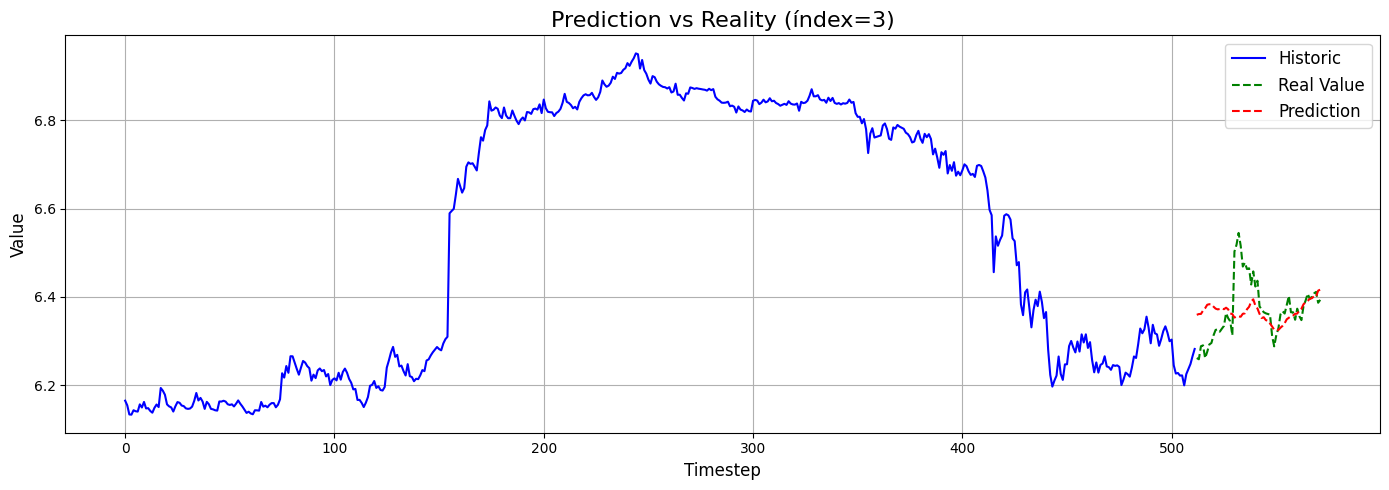

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


channel_idx =3
time_index = 3

# Extrae los datos correspondientes
history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

# Graficar
plt.figure(figsize=(14, 5))
plt.plot(range(len(history)), history, label='Historic', color='blue')
plt.plot(range(len(history), len(history) + len(true)), true, label='Real Value', color='green', linestyle='--')
plt.plot(range(len(history), len(history) + len(pred)), pred, label='Prediction', color='red', linestyle='--')
plt.title(f"Prediction vs Reality (índex={time_index})", fontsize=16)
plt.xlabel("Timestep", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### 4.1.9 Interpretation
We see that the forecast is not as good as we expected. No matter if we change the channel index or the time index, the forecast does not perform as well as in the other cases, at least when fine-tuning the head with a 60-day forecasting horizon.

## 4.2 Model especification 2
Following the same code structure and fine-tuning only the head parameters, we will change only the forecast horizon. The results can be seen in the graph after each epoch process

In [ ]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-base",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 120,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
)

In [ ]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=768, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            

/home/fernando/.local/lib/python3.10/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [ ]:
from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x_enc=x)
pprint(output)

TimeseriesOutputs(forecast=tensor([[[ 0.1759,  0.1594, -0.0200,  ...,  0.2847, -0.2787, -0.1859]],

        [[ 0.2219,  0.3870,  0.4124,  ...,  0.4103, -0.3290,  0.1002]],

        [[-0.0007,  0.0083,  0.4294,  ...,  0.2722, -0.1820, -0.1535]],

        ...,

        [[ 0.1390, -0.0701,  0.3597,  ...,  0.3903, -0.0351, -0.1121]],

        [[-0.0679, -0.1823,  0.4508,  ...,  0.2967, -0.1565, -0.0176]],

        [[ 0.0234,  0.2356,  0.2850,  ...,  0.3842, -0.3836,  0.0975]]],
       grad_fn=<AddBackward0>),
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=None,
                  reconstruction=None,
                  embedding

In [ ]:
from typing import Optional
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


class InformerDataset:
    def __init__(
        self,
        forecast_horizon: Optional[int] = 120,
        data_split: str = "train",
        data_stride_len: int = 1,
        task_name: str = "forecasting",
        random_seed: int = 42,
    ):
        """
        Parameters
        ----------
        forecast_horizon : int
            Length of the prediction sequence.
        data_split : str
            Split of the dataset, 'train' or 'test'.
        data_stride_len : int
            Stride length when generating consecutive
            time series windows.
        task_name : str
            The task that the dataset is used for. One of
            'forecasting', or  'imputation'.
        random_seed : int
            Random seed for reproducibility.
        """

        self.seq_len = 512
        self.forecast_horizon = forecast_horizon
        print(self.forecast_horizon)
        self.full_file_path_and_name = "Documents/said/intento 6.csv"
        self.data_split = data_split
        self.data_stride_len = data_stride_len
        self.task_name = task_name
        self.random_seed = random_seed

        # Read data
        self._read_data()

    def _get_borders(self):
        total = self.length_timeseries_original
        n_train = int(0.60 * total)
        n_val = int(0.20 * total)
        n_test = total - n_train - n_val

        train_end = n_train
        val_end = n_train + n_val
        test_start = val_end - self.seq_len
        test_end = test_start + n_test + self.seq_len

        train = slice(0, train_end)
        test = slice(test_start, test_end)
        print(f"Train: {train}")
        print(f"Test: {test}")

        return train, test

    def _read_data(self):
        self.scaler = StandardScaler()
        df = pd.read_csv(self.full_file_path_and_name)
        self.length_timeseries_original = df.shape[0]
        self.n_channels = df.shape[1] - 1

        df.drop(columns=["date"], inplace=True)
        df = df.infer_objects(copy=False).interpolate(method="cubic")

        data_splits = self._get_borders()

        train_data = df[data_splits[0]]
        self.scaler.fit(train_data.values)
        df = self.scaler.transform(df.values)

        if self.data_split == "train":
            self.data = df[data_splits[0], :]
        elif self.data_split == "test":
            self.data = df[data_splits[1], :]

        self.length_timeseries = self.data.shape[0]
        print(df)
        print(f"Length of timeseries: {self.length_timeseries}")
        print("Longitud de la serie:", self.length_timeseries)
        print("Seq len:", self.seq_len)
        print("Forecast horizon:", self.forecast_horizon)

    def __getitem__(self, index):
        seq_start = self.data_stride_len * index
        seq_end = seq_start + self.seq_len
        input_mask = np.ones(self.seq_len)

        if self.task_name == "forecasting":
            pred_end = seq_end + self.forecast_horizon

            if pred_end > self.length_timeseries:
                pred_end = self.length_timeseries
                seq_end = seq_end - self.forecast_horizon
                seq_start = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T
            forecast = self.data[seq_end:pred_end, :].T

            return timeseries, forecast, input_mask

        elif self.task_name == "imputation":
            if seq_end > self.length_timeseries:
                seq_end = self.length_timeseries
                seq_end = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T

            return timeseries, input_mask

    def __len__(self):
        if self.task_name == "imputation":
            return (self.length_timeseries - self.seq_len) // self.data_stride_len + 1
        elif self.task_name == "forecasting":
            return (
                self.length_timeseries - self.seq_len - self.forecast_horizon
            ) // self.data_stride_len + 1

In [ ]:
import numpy as np
import torch
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from momentfm.utils.utils import control_randomness
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13)

# Load data
train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=120)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = InformerDataset(data_split="test", random_seed=13, forecast_horizon=120)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cur_epoch = 0
max_epoch = 75

# Move the model to the GPU
model = model.to(device)

# Move the loss function to the GPU
criterion = criterion.to(device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create a OneCycleLR scheduler
max_lr = 1e-4
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping value
max_norm = 5.0

while cur_epoch < max_epoch:
    losses = []
    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)

        with torch.cuda.amp.autocast():
            output = model(x_enc=timeseries, input_mask=input_mask)

        loss = criterion(output.forecast, forecast)

        # Scales the loss for mixed precision training
        scaler.scale(loss).backward()

        # Clip gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    print(f"Epoch {cur_epoch}: Train loss: {average_loss:.3f}")

    # Step the learning rate scheduler
    scheduler.step()
    cur_epoch += 1

    # Evaluate the model on the test split
    trues, preds, histories, losses = [], [], [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in tqdm(test_loader, total=len(test_loader)):
        # Move the data to the GPU
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            with torch.cuda.amp.autocast():
                output = model(x_enc=timeseries, input_mask=input_mask)

            loss = criterion(output.forecast, forecast)
            losses.append(loss.item())

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())
            histories.append(timeseries.detach().cpu().numpy())

    losses = np.array(losses)
    average_loss = np.average(losses)
    model.train()

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)

    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')

    print(f"Epoch {cur_epoch}: Test MSE: {metrics.mse:.3f} | Test MAE: {metrics.mae:.3f}")


120
Train: slice(0, 11857, None)
Test: slice(15297, 19762, None)
[[-1.79998097 -1.80794455 -1.80637109 -1.8074823 ]
 [-1.80965046 -1.8159859  -1.82833614 -1.83377792]
 [-1.82727244 -1.83622479 -1.83339804 -1.84218167]
 ...
 [ 5.3173981   5.31723015  5.32232753  5.31402224]
 [ 5.31423518  5.31867579  5.31789837  5.31067881]
 [ 5.31025895  5.33069263  5.31645211  5.32712487]]
Length of timeseries: 11857
Longitud de la serie: 11857
Seq len: 512
Forecast horizon: 120
120
Train: slice(0, 11857, None)
Test: slice(15297, 19762, None)
[[-1.79998097 -1.80794455 -1.80637109 -1.8074823 ]
 [-1.80965046 -1.8159859  -1.82833614 -1.83377792]
 [-1.82727244 -1.83622479 -1.83339804 -1.84218167]
 ...
 [ 5.3173981   5.31723015  5.32232753  5.31402224]
 [ 5.31423518  5.31867579  5.31789837  5.31067881]
 [ 5.31025895  5.33069263  5.31645211  5.32712487]]
Length of timeseries: 4465
Longitud de la serie: 4465
Seq len: 512
Forecast horizon: 120


/tmp/ipykernel_72580/2929178898.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|                                                  | 0/1404 [00:00<?, ?it/s]/tmp/ipykernel_72580/2929178898.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/fernando/.local/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/fernando/.local/lib/python3.1

Epoch 0: Train loss: 0.043


  0%|                                                   | 0/480 [00:00<?, ?it/s]/tmp/ipykernel_72580/2929178898.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 50.68it/s]


Epoch 1: Test MSE: 0.044 | Test MAE: 0.134


100%|███████████████████████████████████████| 1404/1404 [00:32<00:00, 43.86it/s]


Epoch 1: Train loss: 0.034


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.29it/s]


Epoch 2: Test MSE: 0.038 | Test MAE: 0.122


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.73it/s]


Epoch 2: Train loss: 0.032


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.22it/s]


Epoch 3: Test MSE: 0.037 | Test MAE: 0.117


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.05it/s]


Epoch 3: Train loss: 0.031


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.31it/s]


Epoch 4: Test MSE: 0.036 | Test MAE: 0.119


100%|███████████████████████████████████████| 1404/1404 [00:33<00:00, 42.06it/s]


Epoch 4: Train loss: 0.031


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 50.19it/s]


Epoch 5: Test MSE: 0.035 | Test MAE: 0.114


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 44.80it/s]


Epoch 5: Train loss: 0.030


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.28it/s]


Epoch 6: Test MSE: 0.035 | Test MAE: 0.113


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 44.62it/s]


Epoch 6: Train loss: 0.029


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.35it/s]


Epoch 7: Test MSE: 0.035 | Test MAE: 0.113


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.16it/s]


Epoch 7: Train loss: 0.029


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.35it/s]


Epoch 8: Test MSE: 0.035 | Test MAE: 0.114


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.87it/s]


Epoch 8: Train loss: 0.029


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.23it/s]


Epoch 9: Test MSE: 0.035 | Test MAE: 0.113


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.04it/s]


Epoch 9: Train loss: 0.028


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.35it/s]


Epoch 10: Test MSE: 0.034 | Test MAE: 0.113


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 45.02it/s]


Epoch 10: Train loss: 0.028


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.27it/s]


Epoch 11: Test MSE: 0.034 | Test MAE: 0.113


100%|███████████████████████████████████████| 1404/1404 [00:32<00:00, 42.92it/s]


Epoch 11: Train loss: 0.028


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.37it/s]


Epoch 12: Test MSE: 0.035 | Test MAE: 0.114


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.13it/s]


Epoch 12: Train loss: 0.027


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.32it/s]


Epoch 13: Test MSE: 0.035 | Test MAE: 0.116


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.87it/s]


Epoch 13: Train loss: 0.027


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.38it/s]


Epoch 14: Test MSE: 0.035 | Test MAE: 0.114


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.06it/s]


Epoch 14: Train loss: 0.027


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.37it/s]


Epoch 15: Test MSE: 0.035 | Test MAE: 0.116


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 44.03it/s]


Epoch 15: Train loss: 0.027


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.37it/s]


Epoch 16: Test MSE: 0.035 | Test MAE: 0.115


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 44.70it/s]


Epoch 16: Train loss: 0.026


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.26it/s]


Epoch 17: Test MSE: 0.037 | Test MAE: 0.119


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 45.22it/s]


Epoch 17: Train loss: 0.026


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.46it/s]


Epoch 18: Test MSE: 0.035 | Test MAE: 0.116


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.21it/s]


Epoch 18: Train loss: 0.026


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.36it/s]


Epoch 19: Test MSE: 0.036 | Test MAE: 0.118


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.70it/s]


Epoch 19: Train loss: 0.026


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.39it/s]


Epoch 20: Test MSE: 0.035 | Test MAE: 0.115


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.24it/s]


Epoch 20: Train loss: 0.026


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.37it/s]


Epoch 21: Test MSE: 0.035 | Test MAE: 0.116


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 44.64it/s]


Epoch 21: Train loss: 0.026


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.20it/s]


Epoch 22: Test MSE: 0.035 | Test MAE: 0.115


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.05it/s]


Epoch 22: Train loss: 0.025


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.33it/s]


Epoch 23: Test MSE: 0.035 | Test MAE: 0.117


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.22it/s]


Epoch 23: Train loss: 0.025


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.34it/s]


Epoch 24: Test MSE: 0.035 | Test MAE: 0.116


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 45.06it/s]


Epoch 24: Train loss: 0.025


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.28it/s]


Epoch 25: Test MSE: 0.035 | Test MAE: 0.115


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.91it/s]


Epoch 25: Train loss: 0.025


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.29it/s]


Epoch 26: Test MSE: 0.035 | Test MAE: 0.115


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.94it/s]


Epoch 26: Train loss: 0.025


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.30it/s]


Epoch 27: Test MSE: 0.035 | Test MAE: 0.116


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.92it/s]


Epoch 27: Train loss: 0.025


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.30it/s]


Epoch 28: Test MSE: 0.035 | Test MAE: 0.117


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 44.10it/s]


Epoch 28: Train loss: 0.025


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.30it/s]


Epoch 29: Test MSE: 0.036 | Test MAE: 0.118


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.86it/s]


Epoch 29: Train loss: 0.024


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.33it/s]


Epoch 30: Test MSE: 0.036 | Test MAE: 0.119


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 45.12it/s]


Epoch 30: Train loss: 0.024


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.36it/s]


Epoch 31: Test MSE: 0.036 | Test MAE: 0.118


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 45.04it/s]


Epoch 31: Train loss: 0.024


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.34it/s]


Epoch 32: Test MSE: 0.036 | Test MAE: 0.118


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.52it/s]


Epoch 32: Train loss: 0.024


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.38it/s]


Epoch 33: Test MSE: 0.036 | Test MAE: 0.119


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.23it/s]


Epoch 33: Train loss: 0.024


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.33it/s]


Epoch 34: Test MSE: 0.037 | Test MAE: 0.120


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.08it/s]


Epoch 34: Train loss: 0.024


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.36it/s]


Epoch 35: Test MSE: 0.036 | Test MAE: 0.117


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.36it/s]


Epoch 35: Train loss: 0.024


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.33it/s]


Epoch 36: Test MSE: 0.036 | Test MAE: 0.117


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.99it/s]


Epoch 36: Train loss: 0.024


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.37it/s]


Epoch 37: Test MSE: 0.037 | Test MAE: 0.120


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.10it/s]


Epoch 37: Train loss: 0.024


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.36it/s]


Epoch 38: Test MSE: 0.036 | Test MAE: 0.120


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 44.87it/s]


Epoch 38: Train loss: 0.023


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.30it/s]


Epoch 39: Test MSE: 0.037 | Test MAE: 0.120


100%|███████████████████████████████████████| 1404/1404 [00:32<00:00, 43.65it/s]


Epoch 39: Train loss: 0.023


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.30it/s]


Epoch 40: Test MSE: 0.037 | Test MAE: 0.121


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.99it/s]


Epoch 40: Train loss: 0.023


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.90it/s]


Epoch 41: Test MSE: 0.036 | Test MAE: 0.118


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.64it/s]


Epoch 41: Train loss: 0.023


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.12it/s]


Epoch 42: Test MSE: 0.037 | Test MAE: 0.122


100%|███████████████████████████████████████| 1404/1404 [00:36<00:00, 38.30it/s]


Epoch 42: Train loss: 0.023


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 50.34it/s]


Epoch 43: Test MSE: 0.037 | Test MAE: 0.120


100%|███████████████████████████████████████| 1404/1404 [00:34<00:00, 41.23it/s]


Epoch 43: Train loss: 0.023


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 50.09it/s]


Epoch 44: Test MSE: 0.037 | Test MAE: 0.120


100%|███████████████████████████████████████| 1404/1404 [00:34<00:00, 40.96it/s]


Epoch 44: Train loss: 0.023


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 50.62it/s]


Epoch 45: Test MSE: 0.037 | Test MAE: 0.120


100%|███████████████████████████████████████| 1404/1404 [00:34<00:00, 41.03it/s]


Epoch 45: Train loss: 0.023


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.10it/s]


Epoch 46: Test MSE: 0.037 | Test MAE: 0.120


100%|███████████████████████████████████████| 1404/1404 [00:33<00:00, 41.99it/s]


Epoch 46: Train loss: 0.023


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 50.65it/s]


Epoch 47: Test MSE: 0.037 | Test MAE: 0.121


100%|███████████████████████████████████████| 1404/1404 [00:33<00:00, 41.75it/s]


Epoch 47: Train loss: 0.023


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.38it/s]


Epoch 48: Test MSE: 0.037 | Test MAE: 0.120


100%|███████████████████████████████████████| 1404/1404 [00:32<00:00, 43.63it/s]


Epoch 48: Train loss: 0.023


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.38it/s]


Epoch 49: Test MSE: 0.037 | Test MAE: 0.120


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 44.92it/s]


Epoch 49: Train loss: 0.022


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.46it/s]


Epoch 50: Test MSE: 0.038 | Test MAE: 0.122


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.68it/s]


Epoch 50: Train loss: 0.022


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.45it/s]


Epoch 51: Test MSE: 0.038 | Test MAE: 0.123


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.71it/s]


Epoch 51: Train loss: 0.022


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.43it/s]


Epoch 52: Test MSE: 0.036 | Test MAE: 0.119


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 45.09it/s]


Epoch 52: Train loss: 0.022


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.50it/s]


Epoch 53: Test MSE: 0.037 | Test MAE: 0.121


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 45.05it/s]


Epoch 53: Train loss: 0.022


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.39it/s]


Epoch 54: Test MSE: 0.037 | Test MAE: 0.122


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 44.78it/s]


Epoch 54: Train loss: 0.022


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.43it/s]


Epoch 55: Test MSE: 0.038 | Test MAE: 0.123


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 44.11it/s]


Epoch 55: Train loss: 0.022


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.34it/s]


Epoch 56: Test MSE: 0.038 | Test MAE: 0.124


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 45.08it/s]


Epoch 56: Train loss: 0.022


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.17it/s]


Epoch 57: Test MSE: 0.038 | Test MAE: 0.122


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.03it/s]


Epoch 57: Train loss: 0.022


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.41it/s]


Epoch 58: Test MSE: 0.038 | Test MAE: 0.122


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.26it/s]


Epoch 58: Train loss: 0.022


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.38it/s]


Epoch 59: Test MSE: 0.038 | Test MAE: 0.123


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 44.94it/s]


Epoch 59: Train loss: 0.022


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.23it/s]


Epoch 60: Test MSE: 0.038 | Test MAE: 0.122


100%|███████████████████████████████████████| 1404/1404 [00:32<00:00, 43.65it/s]


Epoch 60: Train loss: 0.022


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.40it/s]


Epoch 61: Test MSE: 0.038 | Test MAE: 0.122


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.04it/s]


Epoch 61: Train loss: 0.022


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.32it/s]


Epoch 62: Test MSE: 0.038 | Test MAE: 0.123


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 44.92it/s]


Epoch 62: Train loss: 0.022


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.42it/s]


Epoch 63: Test MSE: 0.038 | Test MAE: 0.123


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.95it/s]


Epoch 63: Train loss: 0.022


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.37it/s]


Epoch 64: Test MSE: 0.038 | Test MAE: 0.124


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 45.01it/s]


Epoch 64: Train loss: 0.022


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.50it/s]


Epoch 65: Test MSE: 0.038 | Test MAE: 0.124


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.10it/s]


Epoch 65: Train loss: 0.022


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.27it/s]


Epoch 66: Test MSE: 0.038 | Test MAE: 0.124


100%|███████████████████████████████████████| 1404/1404 [00:32<00:00, 42.63it/s]


Epoch 66: Train loss: 0.021


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 50.39it/s]


Epoch 67: Test MSE: 0.037 | Test MAE: 0.122


100%|███████████████████████████████████████| 1404/1404 [00:33<00:00, 41.42it/s]


Epoch 67: Train loss: 0.021


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.42it/s]


Epoch 68: Test MSE: 0.038 | Test MAE: 0.123


100%|███████████████████████████████████████| 1404/1404 [00:31<00:00, 45.07it/s]


Epoch 68: Train loss: 0.021


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.25it/s]


Epoch 69: Test MSE: 0.038 | Test MAE: 0.123


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.66it/s]


Epoch 69: Train loss: 0.021


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.42it/s]


Epoch 70: Test MSE: 0.039 | Test MAE: 0.125


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.98it/s]


Epoch 70: Train loss: 0.021


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.39it/s]


Epoch 71: Test MSE: 0.038 | Test MAE: 0.125


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.13it/s]


Epoch 71: Train loss: 0.021


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.13it/s]


Epoch 72: Test MSE: 0.038 | Test MAE: 0.124


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.76it/s]


Epoch 72: Train loss: 0.021


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.28it/s]


Epoch 73: Test MSE: 0.039 | Test MAE: 0.125


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 45.71it/s]


Epoch 73: Train loss: 0.021


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.41it/s]


Epoch 74: Test MSE: 0.039 | Test MAE: 0.125


100%|███████████████████████████████████████| 1404/1404 [00:30<00:00, 46.02it/s]


Epoch 74: Train loss: 0.021


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 52.40it/s]

Epoch 75: Test MSE: 0.039 | Test MAE: 0.124


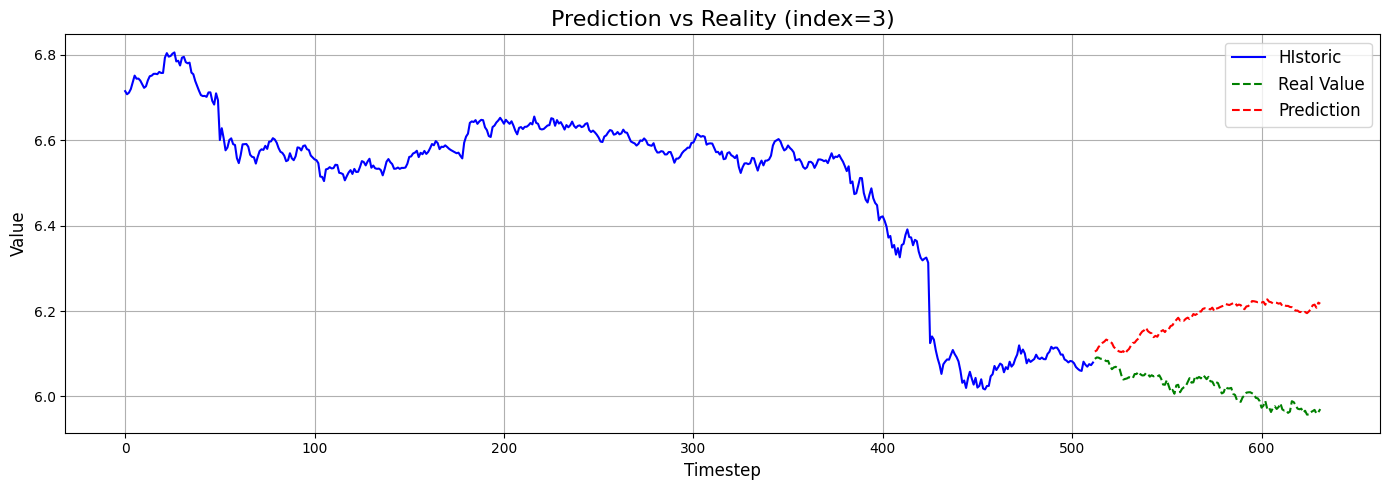

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


channel_idx = 3
time_index = 3

# Extrae los datos correspondientes
history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

# Graficar
plt.figure(figsize=(14, 5))
plt.plot(range(len(history)), history, label='HIstoric', color='blue')
plt.plot(range(len(history), len(history) + len(true)), true, label='Real Value', color='green', linestyle='--')
plt.plot(range(len(history), len(history) + len(pred)), pred, label='Prediction', color='red', linestyle='--')

plt.title(f"Prediction vs Reality (index={time_index})", fontsize=16)
plt.xlabel("Timestep", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

##4.3  Model especification 3

In [ ]:
from momentfm import MOMENTPipeline
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-base",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 180,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
)

In [ ]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=768, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            

/home/fernando/.local/lib/python3.10/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [ ]:
from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x_enc=x)
pprint(output)

TimeseriesOutputs(forecast=tensor([[[ 0.1703,  0.0430,  0.4378,  ...,  0.5492,  0.2588,  0.2874]],

        [[-0.0079,  0.2920,  0.2192,  ...,  0.4747,  0.2110,  0.2507]],

        [[-0.0126, -0.0100,  0.4359,  ..., -0.0100,  0.1221,  0.0945]],

        ...,

        [[ 0.0185,  0.0276,  0.0185,  ...,  0.4107, -0.0811,  0.2348]],

        [[ 0.0646,  0.1766,  0.5563,  ...,  0.3747,  0.2119,  0.4272]],

        [[-0.0278,  0.1087,  0.2509,  ...,  0.4551, -0.0018,  0.1695]]],
       grad_fn=<AddBackward0>),
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=None,
                  reconstruction=None,
                  embedding

In [ ]:
from typing import Optional
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


class InformerDataset:
    def __init__(
        self,
        forecast_horizon: Optional[int] = 180,
        data_split: str = "train",
        data_stride_len: int = 1,
        task_name: str = "forecasting",
        random_seed: int = 42,
    ):
        """
        Parameters
        ----------
        forecast_horizon : int
            Length of the prediction sequence.
        data_split : str
            Split of the dataset, 'train' or 'test'.
        data_stride_len : int
            Stride length when generating consecutive
            time series windows.
        task_name : str
            The task that the dataset is used for. One of
            'forecasting', or  'imputation'.
        random_seed : int
            Random seed for reproducibility.
        """

        self.seq_len = 512
        self.forecast_horizon = forecast_horizon
        self.full_file_path_and_name = "Documents/said/intento 6.csv"
        self.data_split = data_split
        self.data_stride_len = data_stride_len
        self.task_name = task_name
        self.random_seed = random_seed

        # Read data
        self._read_data()

    def _get_borders(self):
        total = self.length_timeseries_original
        n_train = int(0.60 * total)
        n_val = int(0.20 * total)
        n_test = total - n_train - n_val

        train_end = n_train
        val_end = n_train + n_val
        test_start = val_end - self.seq_len
        test_end = test_start + n_test + self.seq_len

        train = slice(0, train_end)
        test = slice(test_start, test_end)
        print(f"Train: {train}")
        print(f"Test: {test}")

        return train, test

    def _read_data(self):
        self.scaler = StandardScaler()
        df = pd.read_csv(self.full_file_path_and_name)
        self.length_timeseries_original = df.shape[0]
        self.n_channels = df.shape[1] - 1

        df.drop(columns=["date"], inplace=True)
        df = df.infer_objects(copy=False).interpolate(method="cubic")

        data_splits = self._get_borders()

        train_data = df[data_splits[0]]
        self.scaler.fit(train_data.values)
        df = self.scaler.transform(df.values)

        if self.data_split == "train":
            self.data = df[data_splits[0], :]
        elif self.data_split == "test":
            self.data = df[data_splits[1], :]

        self.length_timeseries = self.data.shape[0]
        print(df)
        print(f"Length of timeseries: {self.length_timeseries}")
        print("Longitud de la serie:", self.length_timeseries)
        print("Seq len:", self.seq_len)
        print("Forecast horizon:", self.forecast_horizon)

    def __getitem__(self, index):
        seq_start = self.data_stride_len * index
        seq_end = seq_start + self.seq_len
        input_mask = np.ones(self.seq_len)

        if self.task_name == "forecasting":
            pred_end = seq_end + self.forecast_horizon

            if pred_end > self.length_timeseries:
                pred_end = self.length_timeseries
                seq_end = seq_end - self.forecast_horizon
                seq_start = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T
            forecast = self.data[seq_end:pred_end, :].T

            return timeseries, forecast, input_mask

        elif self.task_name == "imputation":
            if seq_end > self.length_timeseries:
                seq_end = self.length_timeseries
                seq_end = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T

            return timeseries, input_mask

    def __len__(self):
        if self.task_name == "imputation":
            return (self.length_timeseries - self.seq_len) // self.data_stride_len + 1
        elif self.task_name == "forecasting":
            return (
                self.length_timeseries - self.seq_len - self.forecast_horizon
            ) // self.data_stride_len + 1

In [ ]:
import numpy as np
import torch
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from momentfm.utils.utils import control_randomness
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13)

# Load data
train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=180)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = InformerDataset(data_split="test", random_seed=13, forecast_horizon=180)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cur_epoch = 0
max_epoch = 75

# Move the model to the GPU
model = model.to(device)

# Move the loss function to the GPU
criterion = criterion.to(device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create a OneCycleLR scheduler
max_lr = 1e-4
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping value
max_norm = 5.0

while cur_epoch < max_epoch:
    losses = []
    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)

        with torch.cuda.amp.autocast():
            output = model(x_enc=timeseries, input_mask=input_mask)

        loss = criterion(output.forecast, forecast)

        # Scales the loss for mixed precision training
        scaler.scale(loss).backward()

        # Clip gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    print(f"Epoch {cur_epoch}: Train loss: {average_loss:.3f}")

    # Step the learning rate scheduler
    scheduler.step()
    cur_epoch += 1

    # Evaluate the model on the test split
    trues, preds, histories, losses = [], [], [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in tqdm(test_loader, total=len(test_loader)):
        # Move the data to the GPU
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            with torch.cuda.amp.autocast():
                output = model(x_enc=timeseries, input_mask=input_mask)

            loss = criterion(output.forecast, forecast)
            losses.append(loss.item())

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())
            histories.append(timeseries.detach().cpu().numpy())

    losses = np.array(losses)
    average_loss = np.average(losses)
    model.train()

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)

    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')

    print(f"Epoch {cur_epoch}: Test MSE: {metrics.mse:.3f} | Test MAE: {metrics.mae:.3f}")


Train: slice(0, 11857, None)
Test: slice(15297, 19762, None)
[[-1.79998097 -1.80794455 -1.80637109 -1.8074823 ]
 [-1.80965046 -1.8159859  -1.82833614 -1.83377792]
 [-1.82727244 -1.83622479 -1.83339804 -1.84218167]
 ...
 [ 5.3173981   5.31723015  5.32232753  5.31402224]
 [ 5.31423518  5.31867579  5.31789837  5.31067881]
 [ 5.31025895  5.33069263  5.31645211  5.32712487]]
Length of timeseries: 11857
Longitud de la serie: 11857
Seq len: 512
Forecast horizon: 180
Train: slice(0, 11857, None)
Test: slice(15297, 19762, None)
[[-1.79998097 -1.80794455 -1.80637109 -1.8074823 ]
 [-1.80965046 -1.8159859  -1.82833614 -1.83377792]
 [-1.82727244 -1.83622479 -1.83339804 -1.84218167]
 ...
 [ 5.3173981   5.31723015  5.32232753  5.31402224]
 [ 5.31423518  5.31867579  5.31789837  5.31067881]
 [ 5.31025895  5.33069263  5.31645211  5.32712487]]
Length of timeseries: 4465
Longitud de la serie: 4465
Seq len: 512
Forecast horizon: 180


/tmp/ipykernel_72580/591174682.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|                                                  | 0/1396 [00:00<?, ?it/s]/tmp/ipykernel_72580/591174682.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/fernando/.local/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/fernando/.local/lib/python3.10/

Epoch 0: Train loss: 0.055


  0%|                                                   | 0/472 [00:00<?, ?it/s]/tmp/ipykernel_72580/591174682.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.32it/s]


Epoch 1: Test MSE: 0.058 | Test MAE: 0.158


100%|███████████████████████████████████████| 1396/1396 [00:36<00:00, 38.48it/s]


Epoch 1: Train loss: 0.045


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.52it/s]


Epoch 2: Test MSE: 0.053 | Test MAE: 0.148


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.76it/s]


Epoch 2: Train loss: 0.043


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.56it/s]


Epoch 3: Test MSE: 0.051 | Test MAE: 0.141


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.39it/s]


Epoch 3: Train loss: 0.042


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.24it/s]


Epoch 4: Test MSE: 0.051 | Test MAE: 0.142


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 44.79it/s]


Epoch 4: Train loss: 0.041


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.18it/s]


Epoch 5: Test MSE: 0.050 | Test MAE: 0.140


100%|███████████████████████████████████████| 1396/1396 [00:35<00:00, 39.79it/s]


Epoch 5: Train loss: 0.040


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.55it/s]


Epoch 6: Test MSE: 0.049 | Test MAE: 0.137


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.52it/s]


Epoch 6: Train loss: 0.039


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.33it/s]


Epoch 7: Test MSE: 0.051 | Test MAE: 0.141


100%|███████████████████████████████████████| 1396/1396 [00:33<00:00, 42.13it/s]


Epoch 7: Train loss: 0.039


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.29it/s]


Epoch 8: Test MSE: 0.049 | Test MAE: 0.138


100%|███████████████████████████████████████| 1396/1396 [00:30<00:00, 45.22it/s]


Epoch 8: Train loss: 0.038


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.26it/s]


Epoch 9: Test MSE: 0.049 | Test MAE: 0.138


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 45.02it/s]


Epoch 9: Train loss: 0.038


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.28it/s]


Epoch 10: Test MSE: 0.048 | Test MAE: 0.136


100%|███████████████████████████████████████| 1396/1396 [00:30<00:00, 45.09it/s]


Epoch 10: Train loss: 0.037


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.30it/s]


Epoch 11: Test MSE: 0.049 | Test MAE: 0.138


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 44.77it/s]


Epoch 11: Train loss: 0.037


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 47.50it/s]


Epoch 12: Test MSE: 0.048 | Test MAE: 0.136


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 43.87it/s]


Epoch 12: Train loss: 0.037


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.30it/s]


Epoch 13: Test MSE: 0.049 | Test MAE: 0.137


100%|███████████████████████████████████████| 1396/1396 [00:33<00:00, 41.38it/s]


Epoch 13: Train loss: 0.036


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.56it/s]


Epoch 14: Test MSE: 0.050 | Test MAE: 0.139


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.70it/s]


Epoch 14: Train loss: 0.036


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.55it/s]


Epoch 15: Test MSE: 0.051 | Test MAE: 0.141


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.74it/s]


Epoch 15: Train loss: 0.036


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.57it/s]


Epoch 16: Test MSE: 0.049 | Test MAE: 0.138


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.88it/s]


Epoch 16: Train loss: 0.035


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.52it/s]


Epoch 17: Test MSE: 0.050 | Test MAE: 0.139


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.89it/s]


Epoch 17: Train loss: 0.035


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.55it/s]


Epoch 18: Test MSE: 0.050 | Test MAE: 0.139


100%|███████████████████████████████████████| 1396/1396 [00:32<00:00, 43.20it/s]


Epoch 18: Train loss: 0.035


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.26it/s]


Epoch 19: Test MSE: 0.050 | Test MAE: 0.139


100%|███████████████████████████████████████| 1396/1396 [00:30<00:00, 45.15it/s]


Epoch 19: Train loss: 0.035


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.27it/s]


Epoch 20: Test MSE: 0.050 | Test MAE: 0.141


100%|███████████████████████████████████████| 1396/1396 [00:33<00:00, 42.05it/s]


Epoch 20: Train loss: 0.034


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.59it/s]


Epoch 21: Test MSE: 0.049 | Test MAE: 0.139


100%|███████████████████████████████████████| 1396/1396 [00:33<00:00, 41.14it/s]


Epoch 21: Train loss: 0.034


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.54it/s]


Epoch 22: Test MSE: 0.049 | Test MAE: 0.139


100%|███████████████████████████████████████| 1396/1396 [00:32<00:00, 42.95it/s]


Epoch 22: Train loss: 0.034


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.15it/s]


Epoch 23: Test MSE: 0.049 | Test MAE: 0.139


100%|███████████████████████████████████████| 1396/1396 [00:30<00:00, 45.06it/s]


Epoch 23: Train loss: 0.034


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.08it/s]


Epoch 24: Test MSE: 0.050 | Test MAE: 0.141


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 44.73it/s]


Epoch 24: Train loss: 0.034


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.26it/s]


Epoch 25: Test MSE: 0.051 | Test MAE: 0.142


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 44.55it/s]


Epoch 25: Train loss: 0.033


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.27it/s]


Epoch 26: Test MSE: 0.050 | Test MAE: 0.140


100%|███████████████████████████████████████| 1396/1396 [00:30<00:00, 45.12it/s]


Epoch 26: Train loss: 0.033


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.24it/s]


Epoch 27: Test MSE: 0.050 | Test MAE: 0.142


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.80it/s]


Epoch 27: Train loss: 0.033


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.54it/s]


Epoch 28: Test MSE: 0.051 | Test MAE: 0.142


100%|███████████████████████████████████████| 1396/1396 [00:32<00:00, 43.21it/s]


Epoch 28: Train loss: 0.033


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.28it/s]


Epoch 29: Test MSE: 0.051 | Test MAE: 0.142


100%|███████████████████████████████████████| 1396/1396 [00:30<00:00, 45.05it/s]


Epoch 29: Train loss: 0.033


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.27it/s]


Epoch 30: Test MSE: 0.050 | Test MAE: 0.141


100%|███████████████████████████████████████| 1396/1396 [00:35<00:00, 39.15it/s]


Epoch 30: Train loss: 0.032


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.29it/s]


Epoch 31: Test MSE: 0.052 | Test MAE: 0.144


100%|███████████████████████████████████████| 1396/1396 [00:33<00:00, 41.35it/s]


Epoch 31: Train loss: 0.032


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.53it/s]


Epoch 32: Test MSE: 0.052 | Test MAE: 0.144


100%|███████████████████████████████████████| 1396/1396 [00:33<00:00, 42.24it/s]


Epoch 32: Train loss: 0.032


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.28it/s]


Epoch 33: Test MSE: 0.053 | Test MAE: 0.145


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 45.00it/s]


Epoch 33: Train loss: 0.032


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.24it/s]


Epoch 34: Test MSE: 0.050 | Test MAE: 0.141


100%|███████████████████████████████████████| 1396/1396 [00:32<00:00, 42.63it/s]


Epoch 34: Train loss: 0.032


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.29it/s]


Epoch 35: Test MSE: 0.049 | Test MAE: 0.140


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 39.93it/s]


Epoch 35: Train loss: 0.032


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.58it/s]


Epoch 36: Test MSE: 0.051 | Test MAE: 0.144


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.61it/s]


Epoch 36: Train loss: 0.032


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.16it/s]


Epoch 37: Test MSE: 0.051 | Test MAE: 0.143


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 44.96it/s]


Epoch 37: Train loss: 0.031


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.29it/s]


Epoch 38: Test MSE: 0.052 | Test MAE: 0.144


100%|███████████████████████████████████████| 1396/1396 [00:30<00:00, 45.19it/s]


Epoch 38: Train loss: 0.031


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.31it/s]


Epoch 39: Test MSE: 0.051 | Test MAE: 0.143


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 44.83it/s]


Epoch 39: Train loss: 0.031


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.99it/s]


Epoch 40: Test MSE: 0.052 | Test MAE: 0.144


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.08it/s]


Epoch 40: Train loss: 0.031


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.56it/s]


Epoch 41: Test MSE: 0.052 | Test MAE: 0.146


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.69it/s]


Epoch 41: Train loss: 0.031


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.39it/s]


Epoch 42: Test MSE: 0.052 | Test MAE: 0.145


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.79it/s]


Epoch 42: Train loss: 0.031


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.55it/s]


Epoch 43: Test MSE: 0.052 | Test MAE: 0.145


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.74it/s]


Epoch 43: Train loss: 0.031


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.52it/s]


Epoch 44: Test MSE: 0.052 | Test MAE: 0.145


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.71it/s]


Epoch 44: Train loss: 0.030


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.30it/s]


Epoch 45: Test MSE: 0.052 | Test MAE: 0.145


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.71it/s]


Epoch 45: Train loss: 0.030


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.50it/s]


Epoch 46: Test MSE: 0.052 | Test MAE: 0.145


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.67it/s]


Epoch 46: Train loss: 0.030


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.53it/s]


Epoch 47: Test MSE: 0.053 | Test MAE: 0.146


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.71it/s]


Epoch 47: Train loss: 0.030


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.47it/s]


Epoch 48: Test MSE: 0.053 | Test MAE: 0.146


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.58it/s]


Epoch 48: Train loss: 0.030


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.16it/s]


Epoch 49: Test MSE: 0.054 | Test MAE: 0.148


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 44.73it/s]


Epoch 49: Train loss: 0.030


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.11it/s]


Epoch 50: Test MSE: 0.053 | Test MAE: 0.146


100%|███████████████████████████████████████| 1396/1396 [00:32<00:00, 42.35it/s]


Epoch 50: Train loss: 0.030


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.52it/s]


Epoch 51: Test MSE: 0.053 | Test MAE: 0.147


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.92it/s]


Epoch 51: Train loss: 0.030


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.54it/s]


Epoch 52: Test MSE: 0.053 | Test MAE: 0.147


100%|███████████████████████████████████████| 1396/1396 [00:34<00:00, 40.81it/s]


Epoch 52: Train loss: 0.030


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.31it/s]


Epoch 53: Test MSE: 0.054 | Test MAE: 0.148


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 43.64it/s]


Epoch 53: Train loss: 0.030


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.26it/s]


Epoch 54: Test MSE: 0.055 | Test MAE: 0.151


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 45.00it/s]


Epoch 54: Train loss: 0.029


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.95it/s]


Epoch 55: Test MSE: 0.054 | Test MAE: 0.149


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 43.82it/s]


Epoch 55: Train loss: 0.029


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.13it/s]


Epoch 56: Test MSE: 0.054 | Test MAE: 0.149


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 44.99it/s]


Epoch 56: Train loss: 0.029


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.30it/s]


Epoch 57: Test MSE: 0.053 | Test MAE: 0.147


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 43.78it/s]


Epoch 57: Train loss: 0.029


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.25it/s]


Epoch 58: Test MSE: 0.054 | Test MAE: 0.148


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 44.03it/s]


Epoch 58: Train loss: 0.029


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.27it/s]


Epoch 59: Test MSE: 0.054 | Test MAE: 0.149


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 44.78it/s]


Epoch 59: Train loss: 0.029


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.31it/s]


Epoch 60: Test MSE: 0.054 | Test MAE: 0.149


100%|███████████████████████████████████████| 1396/1396 [00:32<00:00, 42.83it/s]


Epoch 60: Train loss: 0.029


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.86it/s]


Epoch 61: Test MSE: 0.054 | Test MAE: 0.149


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 43.90it/s]


Epoch 61: Train loss: 0.029


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.27it/s]


Epoch 62: Test MSE: 0.054 | Test MAE: 0.149


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 44.96it/s]


Epoch 62: Train loss: 0.029


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.34it/s]


Epoch 63: Test MSE: 0.054 | Test MAE: 0.148


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 44.01it/s]


Epoch 63: Train loss: 0.029


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.27it/s]


Epoch 64: Test MSE: 0.055 | Test MAE: 0.149


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 43.84it/s]


Epoch 64: Train loss: 0.029


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.32it/s]


Epoch 65: Test MSE: 0.054 | Test MAE: 0.149


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 45.01it/s]


Epoch 65: Train loss: 0.028


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.30it/s]


Epoch 66: Test MSE: 0.055 | Test MAE: 0.150


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 44.82it/s]


Epoch 66: Train loss: 0.028


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.31it/s]


Epoch 67: Test MSE: 0.055 | Test MAE: 0.150


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 43.68it/s]


Epoch 67: Train loss: 0.028


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.25it/s]


Epoch 68: Test MSE: 0.054 | Test MAE: 0.150


100%|███████████████████████████████████████| 1396/1396 [00:30<00:00, 45.11it/s]


Epoch 68: Train loss: 0.028


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.03it/s]


Epoch 69: Test MSE: 0.054 | Test MAE: 0.149


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 44.72it/s]


Epoch 69: Train loss: 0.028


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.22it/s]


Epoch 70: Test MSE: 0.055 | Test MAE: 0.150


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 43.68it/s]


Epoch 70: Train loss: 0.028


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.31it/s]


Epoch 71: Test MSE: 0.055 | Test MAE: 0.151


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 44.31it/s]


Epoch 71: Train loss: 0.028


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.43it/s]


Epoch 72: Test MSE: 0.054 | Test MAE: 0.149


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 44.99it/s]


Epoch 72: Train loss: 0.028


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.18it/s]


Epoch 73: Test MSE: 0.055 | Test MAE: 0.150


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 44.12it/s]


Epoch 73: Train loss: 0.028


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.20it/s]


Epoch 74: Test MSE: 0.055 | Test MAE: 0.150


100%|███████████████████████████████████████| 1396/1396 [00:31<00:00, 45.02it/s]


Epoch 74: Train loss: 0.028


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 52.07it/s]


Epoch 75: Test MSE: 0.056 | Test MAE: 0.151


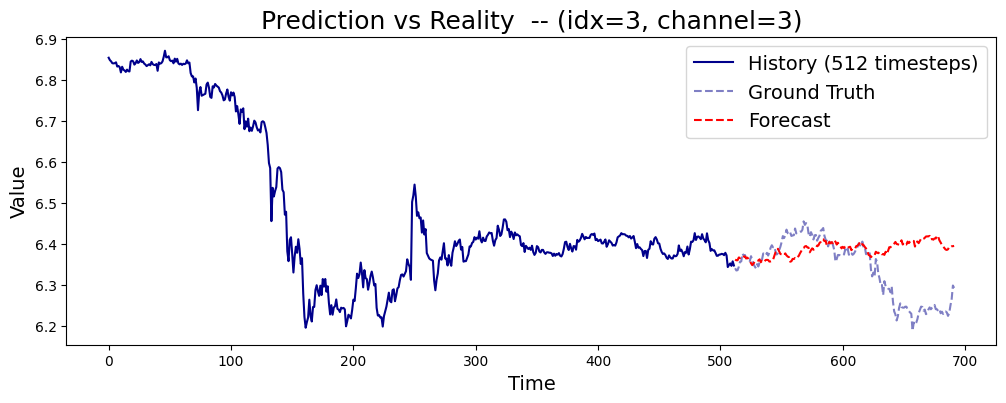

In [ ]:
import matplotlib.pyplot as plt

# Assuming histories, trues, and preds are your lists containing the data
# Extracting the first data point

channel_idx = 3
time_index = 3

history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label='History (512 timesteps)', c='darkblue')

# Plotting ground truth and prediction
num_forecasts = len(true)

offset = len(history)
plt.plot(range(offset, offset + len(true)), true, label='Ground Truth ', color='darkblue', linestyle='--', alpha=0.5)
plt.plot(range(offset, offset + len(pred)), pred, label='Forecast', color='red', linestyle='--')

plt.title(f"Prediction vs Reality  -- (idx={time_index}, channel={channel_idx})", fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=14)
plt.show()

##4.4 Model specifiaction 4

In [ ]:
from momentfm import MOMENTPipeline
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-base",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 240,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
)

In [ ]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=768, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            

/home/fernando/.local/lib/python3.10/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [ ]:
from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x_enc=x)
pprint(output)

TimeseriesOutputs(forecast=tensor([[[-0.0585,  0.1840,  0.3430,  ...,  0.0169,  0.1497,  0.2618]],

        [[ 0.0793,  0.1422,  0.4210,  ..., -0.1017,  0.2309,  0.0819]],

        [[ 0.2129,  0.0297,  0.2888,  ...,  0.0297,  0.3732,  0.0571]],

        ...,

        [[ 0.1044,  0.1050,  0.3847,  ...,  0.0817,  0.5161, -0.1544]],

        [[ 0.1135,  0.0444,  0.1701,  ...,  0.2258,  0.3307,  0.0889]],

        [[-0.0157,  0.1677,  0.3007,  ...,  0.0286,  0.1331, -0.0476]]],
       grad_fn=<AddBackward0>),
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=None,
                  reconstruction=None,
                  embedding

In [ ]:
from typing import Optional
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


class InformerDataset:
    def __init__(
        self,
        forecast_horizon: Optional[int] = 240,
        data_split: str = "train",
        data_stride_len: int = 1,
        task_name: str = "forecasting",
        random_seed: int = 42,
    ):
        """
        Parameters
        ----------
        forecast_horizon : int
            Length of the prediction sequence.
        data_split : str
            Split of the dataset, 'train' or 'test'.
        data_stride_len : int
            Stride length when generating consecutive
            time series windows.
        task_name : str
            The task that the dataset is used for. One of
            'forecasting', or  'imputation'.
        random_seed : int
            Random seed for reproducibility.
        """

        self.seq_len = 512
        self.forecast_horizon = forecast_horizon
        self.full_file_path_and_name = "Documents/said/intento 6.csv"
        self.data_split = data_split
        self.data_stride_len = data_stride_len
        self.task_name = task_name
        self.random_seed = random_seed

        # Read data
        self._read_data()

    def _get_borders(self):
        total = self.length_timeseries_original
        n_train = int(0.60 * total)
        n_val = int(0.20 * total)
        n_test = total - n_train - n_val

        train_end = n_train
        val_end = n_train + n_val
        test_start = val_end - self.seq_len
        test_end = test_start + n_test + self.seq_len

        train = slice(0, train_end)
        test = slice(test_start, test_end)
        print(f"Train: {train}")
        print(f"Test: {test}")

        return train, test

    def _read_data(self):
        self.scaler = StandardScaler()
        df = pd.read_csv(self.full_file_path_and_name)
        self.length_timeseries_original = df.shape[0]
        self.n_channels = df.shape[1] - 1

        df.drop(columns=["date"], inplace=True)
        df = df.infer_objects(copy=False).interpolate(method="cubic")

        data_splits = self._get_borders()

        train_data = df[data_splits[0]]
        self.scaler.fit(train_data.values)
        df = self.scaler.transform(df.values)

        if self.data_split == "train":
            self.data = df[data_splits[0], :]
        elif self.data_split == "test":
            self.data = df[data_splits[1], :]

        self.length_timeseries = self.data.shape[0]
        print(df)
        print(f"Length of timeseries: {self.length_timeseries}")
        print("Longitud de la serie:", self.length_timeseries)
        print("Seq len:", self.seq_len)
        print("Forecast horizon:", self.forecast_horizon)

    def __getitem__(self, index):
        seq_start = self.data_stride_len * index
        seq_end = seq_start + self.seq_len
        input_mask = np.ones(self.seq_len)

        if self.task_name == "forecasting":
            pred_end = seq_end + self.forecast_horizon

            if pred_end > self.length_timeseries:
                pred_end = self.length_timeseries
                seq_end = seq_end - self.forecast_horizon
                seq_start = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T
            forecast = self.data[seq_end:pred_end, :].T

            return timeseries, forecast, input_mask

        elif self.task_name == "imputation":
            if seq_end > self.length_timeseries:
                seq_end = self.length_timeseries
                seq_end = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T

            return timeseries, input_mask

    def __len__(self):
        if self.task_name == "imputation":
            return (self.length_timeseries - self.seq_len) // self.data_stride_len + 1
        elif self.task_name == "forecasting":
            return (
                self.length_timeseries - self.seq_len - self.forecast_horizon
            ) // self.data_stride_len + 1

In [ ]:
import numpy as np
import torch
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from momentfm.utils.utils import control_randomness
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13)

# Load data
train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=240)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = InformerDataset(data_split="test", random_seed=13, forecast_horizon=240)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cur_epoch = 0
max_epoch = 75

# Move the model to the GPU
model = model.to(device)

# Move the loss function to the GPU
criterion = criterion.to(device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create a OneCycleLR scheduler
max_lr = 1e-4
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping value
max_norm = 5.0

while cur_epoch < max_epoch:
    losses = []
    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)

        with torch.cuda.amp.autocast():
            output = model(x_enc=timeseries, input_mask=input_mask)

        loss = criterion(output.forecast, forecast)

        # Scales the loss for mixed precision training
        scaler.scale(loss).backward()

        # Clip gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    print(f"Epoch {cur_epoch}: Train loss: {average_loss:.3f}")

    # Step the learning rate scheduler
    scheduler.step()
    cur_epoch += 1

    # Evaluate the model on the test split
    trues, preds, histories, losses = [], [], [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in tqdm(test_loader, total=len(test_loader)):
        # Move the data to the GPU
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            with torch.cuda.amp.autocast():
                output = model(x_enc=timeseries, input_mask=input_mask)

            loss = criterion(output.forecast, forecast)
            losses.append(loss.item())

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())
            histories.append(timeseries.detach().cpu().numpy())

    losses = np.array(losses)
    average_loss = np.average(losses)
    model.train()

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)

    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')

    print(f"Epoch {cur_epoch}: Test MSE: {metrics.mse:.3f} | Test MAE: {metrics.mae:.3f}")


/tmp/ipykernel_72580/4121414531.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Train: slice(0, 11857, None)
Test: slice(15297, 19762, None)
[[-1.79998097 -1.80794455 -1.80637109 -1.8074823 ]
 [-1.80965046 -1.8159859  -1.82833614 -1.83377792]
 [-1.82727244 -1.83622479 -1.83339804 -1.84218167]
 ...
 [ 5.3173981   5.31723015  5.32232753  5.31402224]
 [ 5.31423518  5.31867579  5.31789837  5.31067881]
 [ 5.31025895  5.33069263  5.31645211  5.32712487]]
Length of timeseries: 11857
Longitud de la serie: 11857
Seq len: 512
Forecast horizon: 240
Train: slice(0, 11857, None)
Test: slice(15297, 19762, None)
[[-1.79998097 -1.80794455 -1.80637109 -1.8074823 ]
 [-1.80965046 -1.8159859  -1.82833614 -1.83377792]
 [-1.82727244 -1.83622479 -1.83339804 -1.84218167]
 ...
 [ 5.3173981   5.31723015  5.32232753  5.31402224]
 [ 5.31423518  5.31867579  5.31789837  5.31067881]
 [ 5.31025895  5.33069263  5.31645211  5.32712487]]
Length of timeseries: 4465
Longitud de la serie: 4465
Seq len: 512
Forecast horizon: 240


  0%|                                                  | 0/1389 [00:00<?, ?it/s]/tmp/ipykernel_72580/4121414531.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/fernando/.local/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/fernando/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|███████████████████████████████████████| 1389/1389 [00:32

Epoch 0: Train loss: 0.066


  0%|                                                   | 0/465 [00:00<?, ?it/s]/tmp/ipykernel_72580/4121414531.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.21it/s]


Epoch 1: Test MSE: 0.075 | Test MAE: 0.186


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.27it/s]


Epoch 1: Train loss: 0.056


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.19it/s]


Epoch 2: Test MSE: 0.069 | Test MAE: 0.174


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.19it/s]


Epoch 2: Train loss: 0.053


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.17it/s]


Epoch 3: Test MSE: 0.066 | Test MAE: 0.166


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.17it/s]


Epoch 3: Train loss: 0.052


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.19it/s]


Epoch 4: Test MSE: 0.065 | Test MAE: 0.164


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.05it/s]


Epoch 4: Train loss: 0.051


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.04it/s]


Epoch 5: Test MSE: 0.064 | Test MAE: 0.160


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 43.08it/s]


Epoch 5: Train loss: 0.050


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.29it/s]


Epoch 6: Test MSE: 0.064 | Test MAE: 0.160


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 43.21it/s]


Epoch 6: Train loss: 0.049


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.19it/s]


Epoch 7: Test MSE: 0.064 | Test MAE: 0.159


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.00it/s]


Epoch 7: Train loss: 0.049


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.17it/s]


Epoch 8: Test MSE: 0.063 | Test MAE: 0.157


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 43.89it/s]


Epoch 8: Train loss: 0.048


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.28it/s]


Epoch 9: Test MSE: 0.064 | Test MAE: 0.159


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.13it/s]


Epoch 9: Train loss: 0.047


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.15it/s]


Epoch 10: Test MSE: 0.064 | Test MAE: 0.159


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.21it/s]


Epoch 10: Train loss: 0.047


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.30it/s]


Epoch 11: Test MSE: 0.062 | Test MAE: 0.156


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.21it/s]


Epoch 11: Train loss: 0.046


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.28it/s]


Epoch 12: Test MSE: 0.065 | Test MAE: 0.161


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 43.16it/s]


Epoch 12: Train loss: 0.046


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.20it/s]


Epoch 13: Test MSE: 0.065 | Test MAE: 0.159


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.19it/s]


Epoch 13: Train loss: 0.046


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 51.87it/s]


Epoch 14: Test MSE: 0.065 | Test MAE: 0.161


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 43.92it/s]


Epoch 14: Train loss: 0.045


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.19it/s]


Epoch 15: Test MSE: 0.065 | Test MAE: 0.161


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 43.07it/s]


Epoch 15: Train loss: 0.045


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.11it/s]


Epoch 16: Test MSE: 0.066 | Test MAE: 0.162


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 42.67it/s]


Epoch 16: Train loss: 0.044


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.02it/s]


Epoch 17: Test MSE: 0.063 | Test MAE: 0.157


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.19it/s]


Epoch 17: Train loss: 0.044


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.21it/s]


Epoch 18: Test MSE: 0.065 | Test MAE: 0.162


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 43.21it/s]


Epoch 18: Train loss: 0.044


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.33it/s]


Epoch 19: Test MSE: 0.065 | Test MAE: 0.160


100%|███████████████████████████████████████| 1389/1389 [00:33<00:00, 41.83it/s]


Epoch 19: Train loss: 0.043


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.31it/s]


Epoch 20: Test MSE: 0.065 | Test MAE: 0.162


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.17it/s]


Epoch 20: Train loss: 0.043


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.24it/s]


Epoch 21: Test MSE: 0.066 | Test MAE: 0.164


100%|███████████████████████████████████████| 1389/1389 [00:33<00:00, 41.92it/s]


Epoch 21: Train loss: 0.043


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.28it/s]


Epoch 22: Test MSE: 0.064 | Test MAE: 0.160


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.03it/s]


Epoch 22: Train loss: 0.043


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.29it/s]


Epoch 23: Test MSE: 0.066 | Test MAE: 0.163


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.04it/s]


Epoch 23: Train loss: 0.042


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.13it/s]


Epoch 24: Test MSE: 0.065 | Test MAE: 0.161


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 43.92it/s]


Epoch 24: Train loss: 0.042


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.57it/s]


Epoch 25: Test MSE: 0.065 | Test MAE: 0.162


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.12it/s]


Epoch 25: Train loss: 0.042


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.04it/s]


Epoch 26: Test MSE: 0.066 | Test MAE: 0.165


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.03it/s]


Epoch 26: Train loss: 0.042


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.03it/s]


Epoch 27: Test MSE: 0.066 | Test MAE: 0.164


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 43.00it/s]


Epoch 27: Train loss: 0.041


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 51.79it/s]


Epoch 28: Test MSE: 0.067 | Test MAE: 0.164


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 43.11it/s]


Epoch 28: Train loss: 0.041


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.16it/s]


Epoch 29: Test MSE: 0.065 | Test MAE: 0.163


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.10it/s]


Epoch 29: Train loss: 0.041


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.19it/s]


Epoch 30: Test MSE: 0.067 | Test MAE: 0.166


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 43.21it/s]


Epoch 30: Train loss: 0.041


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.30it/s]


Epoch 31: Test MSE: 0.067 | Test MAE: 0.166


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 43.08it/s]


Epoch 31: Train loss: 0.041


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.21it/s]


Epoch 32: Test MSE: 0.068 | Test MAE: 0.166


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 43.78it/s]


Epoch 32: Train loss: 0.040


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.32it/s]


Epoch 33: Test MSE: 0.067 | Test MAE: 0.165


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.13it/s]


Epoch 33: Train loss: 0.040


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.24it/s]


Epoch 34: Test MSE: 0.065 | Test MAE: 0.163


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.35it/s]


Epoch 34: Train loss: 0.040


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.32it/s]


Epoch 35: Test MSE: 0.066 | Test MAE: 0.164


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 43.13it/s]


Epoch 35: Train loss: 0.040


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.20it/s]


Epoch 36: Test MSE: 0.067 | Test MAE: 0.165


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 42.97it/s]


Epoch 36: Train loss: 0.040


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.13it/s]


Epoch 37: Test MSE: 0.067 | Test MAE: 0.167


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 42.81it/s]


Epoch 37: Train loss: 0.039


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.23it/s]


Epoch 38: Test MSE: 0.067 | Test MAE: 0.166


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 43.12it/s]


Epoch 38: Train loss: 0.039


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.29it/s]


Epoch 39: Test MSE: 0.067 | Test MAE: 0.166


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 43.99it/s]


Epoch 39: Train loss: 0.039


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.20it/s]


Epoch 40: Test MSE: 0.067 | Test MAE: 0.166


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 43.97it/s]


Epoch 40: Train loss: 0.039


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.16it/s]


Epoch 41: Test MSE: 0.068 | Test MAE: 0.166


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 42.89it/s]


Epoch 41: Train loss: 0.039


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.30it/s]


Epoch 42: Test MSE: 0.067 | Test MAE: 0.165


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.14it/s]


Epoch 42: Train loss: 0.038


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.27it/s]


Epoch 43: Test MSE: 0.067 | Test MAE: 0.165


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 43.01it/s]


Epoch 43: Train loss: 0.038


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.20it/s]


Epoch 44: Test MSE: 0.068 | Test MAE: 0.167


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 42.88it/s]


Epoch 44: Train loss: 0.038


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.30it/s]


Epoch 45: Test MSE: 0.067 | Test MAE: 0.166


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 42.72it/s]


Epoch 45: Train loss: 0.038


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.33it/s]


Epoch 46: Test MSE: 0.068 | Test MAE: 0.167


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 43.68it/s]


Epoch 46: Train loss: 0.038


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.12it/s]


Epoch 47: Test MSE: 0.067 | Test MAE: 0.167


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.05it/s]


Epoch 47: Train loss: 0.038


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.28it/s]


Epoch 48: Test MSE: 0.067 | Test MAE: 0.166


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.16it/s]


Epoch 48: Train loss: 0.038


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.25it/s]


Epoch 49: Test MSE: 0.069 | Test MAE: 0.169


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 43.08it/s]


Epoch 49: Train loss: 0.038


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.31it/s]


Epoch 50: Test MSE: 0.068 | Test MAE: 0.167


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.24it/s]


Epoch 50: Train loss: 0.037


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.25it/s]


Epoch 51: Test MSE: 0.069 | Test MAE: 0.169


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 43.02it/s]


Epoch 51: Train loss: 0.037


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.22it/s]


Epoch 52: Test MSE: 0.068 | Test MAE: 0.168


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.03it/s]


Epoch 52: Train loss: 0.037


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.15it/s]


Epoch 53: Test MSE: 0.069 | Test MAE: 0.169


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 43.97it/s]


Epoch 53: Train loss: 0.037


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.01it/s]


Epoch 54: Test MSE: 0.070 | Test MAE: 0.172


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.11it/s]


Epoch 54: Train loss: 0.037


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.20it/s]


Epoch 55: Test MSE: 0.068 | Test MAE: 0.168


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.17it/s]


Epoch 55: Train loss: 0.037


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.21it/s]


Epoch 56: Test MSE: 0.070 | Test MAE: 0.171


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 43.98it/s]


Epoch 56: Train loss: 0.037


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.11it/s]


Epoch 57: Test MSE: 0.071 | Test MAE: 0.172


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 42.19it/s]


Epoch 57: Train loss: 0.037


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.27it/s]


Epoch 58: Test MSE: 0.070 | Test MAE: 0.171


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.06it/s]


Epoch 58: Train loss: 0.036


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.26it/s]


Epoch 59: Test MSE: 0.068 | Test MAE: 0.168


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.07it/s]


Epoch 59: Train loss: 0.036


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 51.87it/s]


Epoch 60: Test MSE: 0.069 | Test MAE: 0.169


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 43.30it/s]


Epoch 60: Train loss: 0.036


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.21it/s]


Epoch 61: Test MSE: 0.069 | Test MAE: 0.170


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 42.29it/s]


Epoch 61: Train loss: 0.036


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.20it/s]


Epoch 62: Test MSE: 0.070 | Test MAE: 0.171


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.04it/s]


Epoch 62: Train loss: 0.036


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.23it/s]


Epoch 63: Test MSE: 0.070 | Test MAE: 0.171


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 42.95it/s]


Epoch 63: Train loss: 0.036


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.07it/s]


Epoch 64: Test MSE: 0.070 | Test MAE: 0.170


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 42.99it/s]


Epoch 64: Train loss: 0.036


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.22it/s]


Epoch 65: Test MSE: 0.071 | Test MAE: 0.173


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 43.20it/s]


Epoch 65: Train loss: 0.036


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.20it/s]


Epoch 66: Test MSE: 0.070 | Test MAE: 0.171


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.12it/s]


Epoch 66: Train loss: 0.035


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.02it/s]


Epoch 67: Test MSE: 0.070 | Test MAE: 0.172


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.12it/s]


Epoch 67: Train loss: 0.035


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.18it/s]


Epoch 68: Test MSE: 0.070 | Test MAE: 0.171


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 42.95it/s]


Epoch 68: Train loss: 0.035


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.11it/s]


Epoch 69: Test MSE: 0.070 | Test MAE: 0.172


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 42.26it/s]


Epoch 69: Train loss: 0.035


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.11it/s]


Epoch 70: Test MSE: 0.072 | Test MAE: 0.174


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.28it/s]


Epoch 70: Train loss: 0.035


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.28it/s]


Epoch 71: Test MSE: 0.071 | Test MAE: 0.172


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.06it/s]


Epoch 71: Train loss: 0.035


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.23it/s]


Epoch 72: Test MSE: 0.071 | Test MAE: 0.173


100%|███████████████████████████████████████| 1389/1389 [00:32<00:00, 43.20it/s]


Epoch 72: Train loss: 0.035


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.05it/s]


Epoch 73: Test MSE: 0.071 | Test MAE: 0.172


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.10it/s]


Epoch 73: Train loss: 0.035


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.20it/s]


Epoch 74: Test MSE: 0.071 | Test MAE: 0.173


100%|███████████████████████████████████████| 1389/1389 [00:31<00:00, 44.07it/s]


Epoch 74: Train loss: 0.035


100%|█████████████████████████████████████████| 465/465 [00:08<00:00, 52.16it/s]


Epoch 75: Test MSE: 0.072 | Test MAE: 0.174


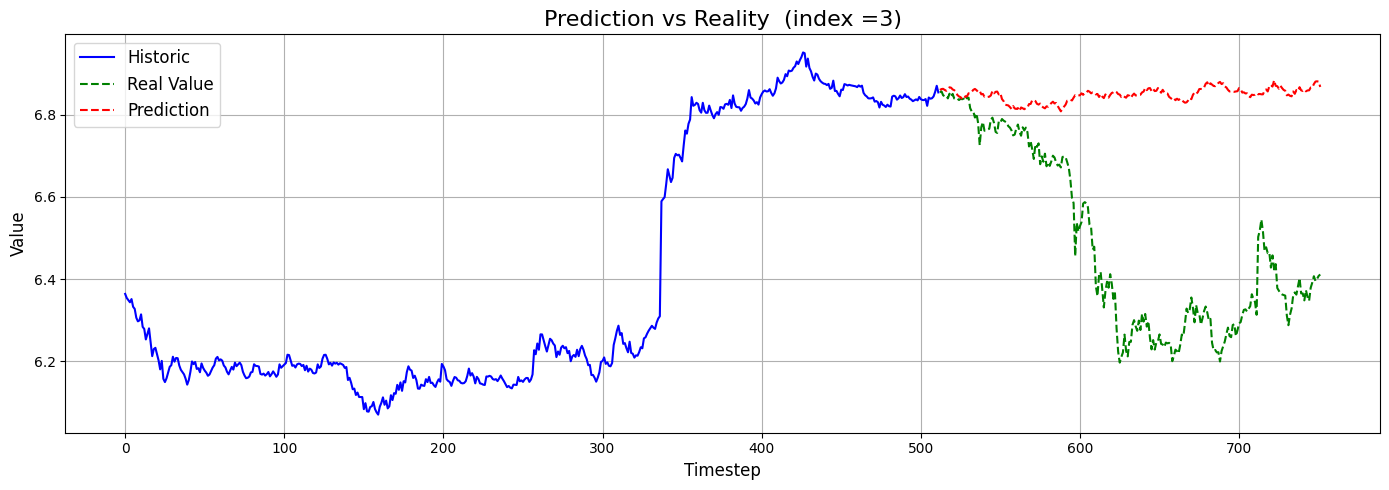

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


channel_idx = 3
time_index = 3

# Extrae los datos correspondientes
history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

# Graficar
plt.figure(figsize=(14, 5))
plt.plot(range(len(history)), history, label='Historic', color='blue')
plt.plot(range(len(history), len(history) + len(true)), true, label='Real Value', color='green', linestyle='--')
plt.plot(range(len(history), len(history) + len(pred)), pred, label='Prediction', color='red', linestyle='--')

plt.title(f"Prediction vs Reality  (index ={time_index})", fontsize=16)
plt.xlabel("Timestep", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Model Formulation
In this document, to demonstrate the effectiveness of the model, we will conduct two types of training. First, we will fine-tune only the head of the model. Alternatively, we will perform a full fine-tuning without freezing any parameters. Between each fine-tuning method, we will evaluate different forecasting horizons to demonstrate accuracy in short-term forecasts (60 and 120 days) and long-term forecasts (240 and 360 days)

## 5.1 Model specification
Having already made and visualized the results of fine-tuning the head for different time horizons, it is now time to do the same but with full fine-tuning. You can see the difference in the code below, where we do not freeze the encoder and set the embedding selection to FALSE.

In [ ]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-base",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 60,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': False, # Freeze the patch embedding layer
        'freeze_embedder': False, # Freeze the transformer encoder
         # The linear forecasting head must be trained
    },
)

### 5.1.1 Model Architecture
We will follow the same structure as the previous models. You can see the difference in the architecture when we freeze and unfreeze the parameters

In [ ]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=768, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            

/home/fernando/.local/lib/python3.10/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [ ]:
from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x_enc=x)
pprint(output)

TimeseriesOutputs(forecast=tensor([[[ 2.2058e-01, -8.6883e-02, -2.5104e-01,  4.1260e-02,  1.3839e-01,
          -2.2843e-01, -2.9094e-01,  1.7572e-01,  1.2877e-01,  4.0961e-01,
          -6.2570e-02,  4.1263e-01,  1.8768e-01, -3.4588e-02,  4.8187e-01,
          -4.3214e-02, -7.4707e-03,  7.1001e-02,  2.8463e-01, -1.4989e-01,
           1.4463e-01,  6.0868e-01,  1.6074e-01,  8.6448e-03, -3.9035e-01,
           2.5625e-01,  9.3238e-02, -2.1647e-01, -1.3473e-01, -1.3925e-01,
           7.7051e-02, -1.2074e-01,  7.5873e-02,  5.4440e-03, -8.5023e-02,
          -2.5637e-01,  2.7506e-01,  2.7697e-02,  5.4440e-03,  2.3839e-01,
          -4.8082e-01,  3.4350e-01, -3.3038e-02,  2.7607e-01,  5.4440e-03,
           5.4440e-03, -9.0742e-02,  2.4640e-01, -2.7454e-01, -2.2825e-01,
          -1.3601e-01, -5.5996e-02,  1.5036e-01, -3.0608e-01,  1.6228e-01,
           5.4440e-03,  3.1470e-01,  3.5492e-02, -3.2474e-01,  2.7740e-01]],

        [[ 2.5250e-01, -3.1955e-01, -2.4963e-01,  2.1669e-02, -1.2344e

In [ ]:
from typing import Optional
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


class InformerDataset:
    def __init__(
        self,
        forecast_horizon: Optional[int] = 60,
        data_split: str = "train",
        data_stride_len: int = 1,
        task_name: str = "forecasting",
        random_seed: int = 42,
    ):
        """
        Parameters
        ----------
        forecast_horizon : int
            Length of the prediction sequence.
        data_split : str
            Split of the dataset, 'train' or 'test'.
        data_stride_len : int
            Stride length when generating consecutive
            time series windows.
        task_name : str
            The task that the dataset is used for. One of
            'forecasting', or  'imputation'.
        random_seed : int
            Random seed for reproducibility.
        """

        self.seq_len = 512
        self.forecast_horizon = forecast_horizon
        self.full_file_path_and_name = "Documents/said/intento 6.csv"
        self.data_split = data_split
        self.data_stride_len = data_stride_len
        self.task_name = task_name
        self.random_seed = random_seed

        # Read data
        self._read_data()

    def _get_borders(self):
        total = self.length_timeseries_original
        n_train = int(0.60 * total)
        n_val = int(0.20 * total)
        n_test = total - n_train - n_val

        train_end = n_train
        val_end = n_train + n_val
        test_start = val_end - self.seq_len
        test_end = test_start + n_test + self.seq_len

        train = slice(0, train_end)
        test = slice(test_start, test_end)
        print(f"Train: {train}")
        print(f"Test: {test}")

        return train, test

    def _read_data(self):
        self.scaler = StandardScaler()
        df = pd.read_csv(self.full_file_path_and_name)
        self.length_timeseries_original = df.shape[0]
        self.n_channels = df.shape[1] - 1

        df.drop(columns=["date"], inplace=True)
        df = df.infer_objects(copy=False).interpolate(method="cubic")

        data_splits = self._get_borders()

        train_data = df[data_splits[0]]
        self.scaler.fit(train_data.values)
        df = self.scaler.transform(df.values)

        if self.data_split == "train":
            self.data = df[data_splits[0], :]
        elif self.data_split == "test":
            self.data = df[data_splits[1], :]

        self.length_timeseries = self.data.shape[0]
        print(df)
        print(f"Length of timeseries: {self.length_timeseries}")
        print("Longitud de la serie:", self.length_timeseries)
        print("Seq len:", self.seq_len)
        print("Forecast horizon:", self.forecast_horizon)

    def __getitem__(self, index):
        seq_start = self.data_stride_len * index
        seq_end = seq_start + self.seq_len
        input_mask = np.ones(self.seq_len)

        if self.task_name == "forecasting":
            pred_end = seq_end + self.forecast_horizon

            if pred_end > self.length_timeseries:
                pred_end = self.length_timeseries
                seq_end = seq_end - self.forecast_horizon
                seq_start = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T
            forecast = self.data[seq_end:pred_end, :].T

            return timeseries, forecast, input_mask

        elif self.task_name == "imputation":
            if seq_end > self.length_timeseries:
                seq_end = self.length_timeseries
                seq_end = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T

            return timeseries, input_mask

    def __len__(self):
        if self.task_name == "imputation":
            return (self.length_timeseries - self.seq_len) // self.data_stride_len + 1
        elif self.task_name == "forecasting":
            return (
                self.length_timeseries - self.seq_len - self.forecast_horizon
            ) // self.data_stride_len + 1

In [ ]:
import numpy as np
import torch
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from momentfm.utils.utils import control_randomness
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13)

# Load data
train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=60)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = InformerDataset(data_split="test", random_seed=13, forecast_horizon=60)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cur_epoch = 0
max_epoch = 75

# Move the model to the GPU
model = model.to(device)

# Move the loss function to the GPU
criterion = criterion.to(device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create a OneCycleLR scheduler
max_lr = 1e-4
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping value
max_norm = 5.0

while cur_epoch < max_epoch:
    losses = []
    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)

        with torch.cuda.amp.autocast():
            output = model(x_enc=timeseries, input_mask=input_mask)

        loss = criterion(output.forecast, forecast)

        # Scales the loss for mixed precision training
        scaler.scale(loss).backward()

        # Clip gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    print(f"Epoch {cur_epoch}: Train loss: {average_loss:.3f}")

    # Step the learning rate scheduler
    scheduler.step()
    cur_epoch += 1

    # Evaluate the model on the test split
    trues, preds, histories, losses = [], [], [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in tqdm(test_loader, total=len(test_loader)):
        # Move the data to the GPU
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            with torch.cuda.amp.autocast():
                output = model(x_enc=timeseries, input_mask=input_mask)

            loss = criterion(output.forecast, forecast)
            losses.append(loss.item())

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())
            histories.append(timeseries.detach().cpu().numpy())

    losses = np.array(losses)
    average_loss = np.average(losses)
    model.train()

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)

    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')

    print(f"Epoch {cur_epoch}: Test MSE: {metrics.mse:.3f} | Test MAE: {metrics.mae:.3f}")


Train: slice(0, 11857, None)
Test: slice(15297, 19762, None)
[[-1.79998097 -1.80794455 -1.80637109 -1.8074823 ]
 [-1.80965046 -1.8159859  -1.82833614 -1.83377792]
 [-1.82727244 -1.83622479 -1.83339804 -1.84218167]
 ...
 [ 5.3173981   5.31723015  5.32232753  5.31402224]
 [ 5.31423518  5.31867579  5.31789837  5.31067881]
 [ 5.31025895  5.33069263  5.31645211  5.32712487]]
Length of timeseries: 11857
Longitud de la serie: 11857
Seq len: 512
Forecast horizon: 60
Train: slice(0, 11857, None)
Test: slice(15297, 19762, None)
[[-1.79998097 -1.80794455 -1.80637109 -1.8074823 ]
 [-1.80965046 -1.8159859  -1.82833614 -1.83377792]
 [-1.82727244 -1.83622479 -1.83339804 -1.84218167]
 ...
 [ 5.3173981   5.31723015  5.32232753  5.31402224]
 [ 5.31423518  5.31867579  5.31789837  5.31067881]
 [ 5.31025895  5.33069263  5.31645211  5.32712487]]
Length of timeseries: 4465
Longitud de la serie: 4465
Seq len: 512
Forecast horizon: 60


/tmp/ipykernel_72580/2121827930.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|                                                  | 0/1411 [00:00<?, ?it/s]/tmp/ipykernel_72580/2121827930.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/fernando/.local/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
100%|██████████████████████████████

Epoch 0: Train loss: 0.021


  0%|                                                   | 0/487 [00:00<?, ?it/s]/tmp/ipykernel_72580/2121827930.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.78it/s]


Epoch 1: Test MSE: 0.020 | Test MAE: 0.086


100%|███████████████████████████████████████| 1411/1411 [03:20<00:00,  7.03it/s]


Epoch 1: Train loss: 0.013


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.79it/s]


Epoch 2: Test MSE: 0.021 | Test MAE: 0.092


100%|███████████████████████████████████████| 1411/1411 [03:24<00:00,  6.89it/s]


Epoch 2: Train loss: 0.011


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.72it/s]


Epoch 3: Test MSE: 0.022 | Test MAE: 0.094


100%|███████████████████████████████████████| 1411/1411 [03:32<00:00,  6.65it/s]


Epoch 3: Train loss: 0.011


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.70it/s]


Epoch 4: Test MSE: 0.023 | Test MAE: 0.095


100%|███████████████████████████████████████| 1411/1411 [03:19<00:00,  7.07it/s]


Epoch 4: Train loss: 0.010


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.61it/s]


Epoch 5: Test MSE: 0.023 | Test MAE: 0.097


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  7.01it/s]


Epoch 5: Train loss: 0.010


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.64it/s]


Epoch 6: Test MSE: 0.024 | Test MAE: 0.097


100%|███████████████████████████████████████| 1411/1411 [03:20<00:00,  7.04it/s]


Epoch 6: Train loss: 0.010


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.72it/s]


Epoch 7: Test MSE: 0.024 | Test MAE: 0.098


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  6.99it/s]


Epoch 7: Train loss: 0.010


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.64it/s]


Epoch 8: Test MSE: 0.024 | Test MAE: 0.099


100%|███████████████████████████████████████| 1411/1411 [03:20<00:00,  7.02it/s]


Epoch 8: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.64it/s]


Epoch 9: Test MSE: 0.025 | Test MAE: 0.100


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  7.01it/s]


Epoch 9: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.66it/s]


Epoch 10: Test MSE: 0.025 | Test MAE: 0.101


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  7.01it/s]


Epoch 10: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.68it/s]


Epoch 11: Test MSE: 0.025 | Test MAE: 0.100


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  7.00it/s]


Epoch 11: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.66it/s]


Epoch 12: Test MSE: 0.025 | Test MAE: 0.100


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  6.99it/s]


Epoch 12: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.74it/s]


Epoch 13: Test MSE: 0.026 | Test MAE: 0.103


100%|███████████████████████████████████████| 1411/1411 [03:19<00:00,  7.09it/s]


Epoch 13: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.64it/s]


Epoch 14: Test MSE: 0.025 | Test MAE: 0.101


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  7.00it/s]


Epoch 14: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.67it/s]


Epoch 15: Test MSE: 0.026 | Test MAE: 0.102


100%|███████████████████████████████████████| 1411/1411 [03:22<00:00,  6.98it/s]


Epoch 15: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.67it/s]


Epoch 16: Test MSE: 0.026 | Test MAE: 0.103


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  6.99it/s]


Epoch 16: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.64it/s]


Epoch 17: Test MSE: 0.026 | Test MAE: 0.103


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  7.01it/s]


Epoch 17: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.64it/s]


Epoch 18: Test MSE: 0.026 | Test MAE: 0.102


100%|███████████████████████████████████████| 1411/1411 [03:22<00:00,  6.97it/s]


Epoch 18: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.62it/s]


Epoch 19: Test MSE: 0.026 | Test MAE: 0.103


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  7.01it/s]


Epoch 19: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 50.83it/s]


Epoch 20: Test MSE: 0.026 | Test MAE: 0.103


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  7.01it/s]


Epoch 20: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.65it/s]


Epoch 21: Test MSE: 0.026 | Test MAE: 0.103


100%|███████████████████████████████████████| 1411/1411 [03:20<00:00,  7.03it/s]


Epoch 21: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.66it/s]


Epoch 22: Test MSE: 0.026 | Test MAE: 0.102


100%|███████████████████████████████████████| 1411/1411 [03:30<00:00,  6.69it/s]


Epoch 22: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.51it/s]


Epoch 23: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:36<00:00,  6.51it/s]


Epoch 23: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.62it/s]


Epoch 24: Test MSE: 0.026 | Test MAE: 0.102


100%|███████████████████████████████████████| 1411/1411 [03:30<00:00,  6.70it/s]


Epoch 24: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.70it/s]


Epoch 25: Test MSE: 0.026 | Test MAE: 0.103


100%|███████████████████████████████████████| 1411/1411 [03:20<00:00,  7.04it/s]


Epoch 25: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.74it/s]


Epoch 26: Test MSE: 0.026 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:11<00:00,  7.36it/s]


Epoch 26: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.57it/s]


Epoch 27: Test MSE: 0.026 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:18<00:00,  7.11it/s]


Epoch 27: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.72it/s]


Epoch 28: Test MSE: 0.026 | Test MAE: 0.103


100%|███████████████████████████████████████| 1411/1411 [03:24<00:00,  6.91it/s]


Epoch 28: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 50.78it/s]


Epoch 29: Test MSE: 0.026 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:15<00:00,  7.20it/s]


Epoch 29: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.65it/s]


Epoch 30: Test MSE: 0.026 | Test MAE: 0.103


100%|███████████████████████████████████████| 1411/1411 [03:25<00:00,  6.88it/s]


Epoch 30: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.74it/s]


Epoch 31: Test MSE: 0.026 | Test MAE: 0.103


100%|███████████████████████████████████████| 1411/1411 [03:25<00:00,  6.87it/s]


Epoch 31: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.61it/s]


Epoch 32: Test MSE: 0.027 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:38<00:00,  6.47it/s]


Epoch 32: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.25it/s]


Epoch 33: Test MSE: 0.026 | Test MAE: 0.103


100%|███████████████████████████████████████| 1411/1411 [03:37<00:00,  6.48it/s]


Epoch 33: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.67it/s]


Epoch 34: Test MSE: 0.026 | Test MAE: 0.103


100%|███████████████████████████████████████| 1411/1411 [03:25<00:00,  6.87it/s]


Epoch 34: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.69it/s]


Epoch 35: Test MSE: 0.027 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:24<00:00,  6.91it/s]


Epoch 35: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.56it/s]


Epoch 36: Test MSE: 0.027 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:20<00:00,  7.05it/s]


Epoch 36: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.53it/s]


Epoch 37: Test MSE: 0.026 | Test MAE: 0.103


100%|███████████████████████████████████████| 1411/1411 [03:20<00:00,  7.02it/s]


Epoch 37: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.63it/s]


Epoch 38: Test MSE: 0.027 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  7.02it/s]


Epoch 38: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.68it/s]


Epoch 39: Test MSE: 0.027 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  6.99it/s]


Epoch 39: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 50.97it/s]


Epoch 40: Test MSE: 0.027 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  6.99it/s]


Epoch 40: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.52it/s]


Epoch 41: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  7.00it/s]


Epoch 41: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.79it/s]


Epoch 42: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  7.02it/s]


Epoch 42: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.85it/s]


Epoch 43: Test MSE: 0.027 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  7.00it/s]


Epoch 43: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.66it/s]


Epoch 44: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:20<00:00,  7.05it/s]


Epoch 44: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.88it/s]


Epoch 45: Test MSE: 0.027 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:20<00:00,  7.02it/s]


Epoch 45: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.79it/s]


Epoch 46: Test MSE: 0.027 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  7.02it/s]


Epoch 46: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.59it/s]


Epoch 47: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [02:43<00:00,  8.64it/s]


Epoch 47: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.46it/s]


Epoch 48: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:20<00:00,  7.03it/s]


Epoch 48: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.59it/s]


Epoch 49: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:21<00:00,  7.01it/s]


Epoch 49: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.67it/s]


Epoch 50: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:18<00:00,  7.12it/s]


Epoch 50: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.38it/s]


Epoch 51: Test MSE: 0.027 | Test MAE: 0.106


100%|███████████████████████████████████████| 1411/1411 [03:19<00:00,  7.08it/s]


Epoch 51: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.61it/s]


Epoch 52: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:20<00:00,  7.03it/s]


Epoch 52: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.46it/s]


Epoch 53: Test MSE: 0.027 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:18<00:00,  7.11it/s]


Epoch 53: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 50.65it/s]


Epoch 54: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:18<00:00,  7.09it/s]


Epoch 54: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.27it/s]


Epoch 55: Test MSE: 0.027 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:19<00:00,  7.08it/s]


Epoch 55: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.63it/s]


Epoch 56: Test MSE: 0.027 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:19<00:00,  7.08it/s]


Epoch 56: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.53it/s]


Epoch 57: Test MSE: 0.027 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:19<00:00,  7.06it/s]


Epoch 57: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 50.80it/s]


Epoch 58: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:19<00:00,  7.07it/s]


Epoch 58: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.60it/s]


Epoch 59: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:19<00:00,  7.06it/s]


Epoch 59: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.70it/s]


Epoch 60: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:20<00:00,  7.04it/s]


Epoch 60: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.44it/s]


Epoch 61: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:20<00:00,  7.03it/s]


Epoch 61: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.54it/s]


Epoch 62: Test MSE: 0.027 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:19<00:00,  7.06it/s]


Epoch 62: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.29it/s]


Epoch 63: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:20<00:00,  7.04it/s]


Epoch 63: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.60it/s]


Epoch 64: Test MSE: 0.027 | Test MAE: 0.104


100%|███████████████████████████████████████| 1411/1411 [03:19<00:00,  7.08it/s]


Epoch 64: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.81it/s]


Epoch 65: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:18<00:00,  7.11it/s]


Epoch 65: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.38it/s]


Epoch 66: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:19<00:00,  7.09it/s]


Epoch 66: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 50.87it/s]


Epoch 67: Test MSE: 0.027 | Test MAE: 0.106


100%|███████████████████████████████████████| 1411/1411 [03:19<00:00,  7.09it/s]


Epoch 67: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.89it/s]


Epoch 68: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:19<00:00,  7.09it/s]


Epoch 68: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.66it/s]


Epoch 69: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:19<00:00,  7.07it/s]


Epoch 69: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.79it/s]


Epoch 70: Test MSE: 0.027 | Test MAE: 0.106


100%|███████████████████████████████████████| 1411/1411 [03:20<00:00,  7.04it/s]


Epoch 70: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.83it/s]


Epoch 71: Test MSE: 0.027 | Test MAE: 0.106


100%|███████████████████████████████████████| 1411/1411 [03:24<00:00,  6.90it/s]


Epoch 71: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.60it/s]


Epoch 72: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:20<00:00,  7.05it/s]


Epoch 72: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.56it/s]


Epoch 73: Test MSE: 0.027 | Test MAE: 0.105


100%|███████████████████████████████████████| 1411/1411 [03:20<00:00,  7.05it/s]


Epoch 73: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 51.67it/s]


Epoch 74: Test MSE: 0.027 | Test MAE: 0.106


100%|███████████████████████████████████████| 1411/1411 [03:25<00:00,  6.88it/s]


Epoch 74: Train loss: 0.009


100%|█████████████████████████████████████████| 487/487 [00:09<00:00, 52.20it/s]

Epoch 75: Test MSE: 0.028 | Test MAE: 0.106


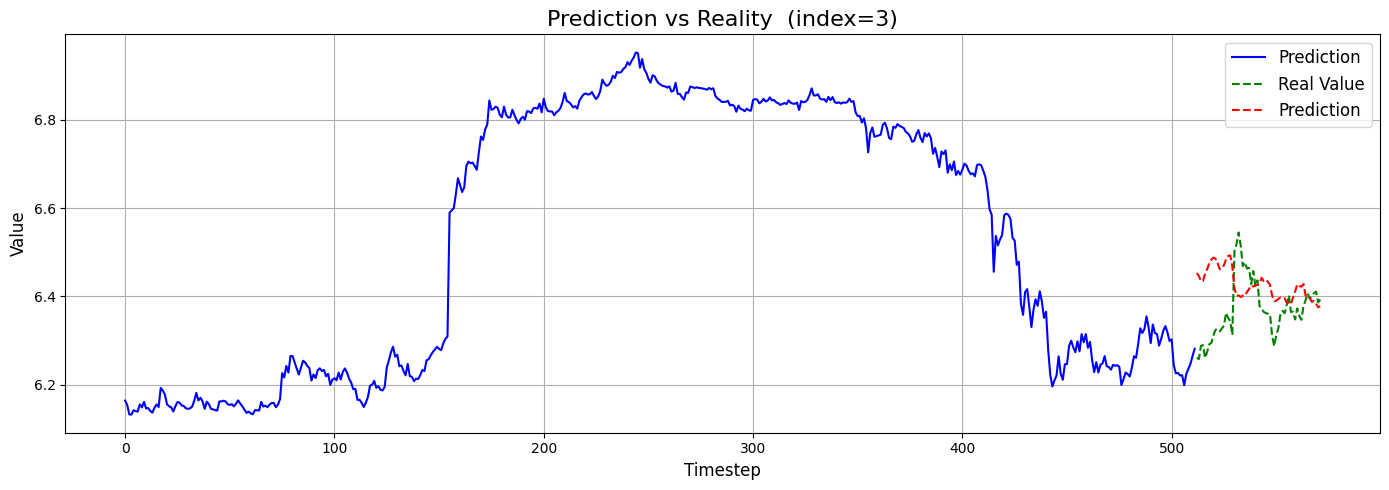

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


channel_idx = 3
time_index = 3

# Extrae los datos correspondientes
history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

# Graficar
plt.figure(figsize=(14, 5))
plt.plot(range(len(history)), history, label='Prediction', color='blue')
plt.plot(range(len(history), len(history) + len(true)), true, label='Real Value', color='green', linestyle='--')
plt.plot(range(len(history), len(history) + len(pred)), pred, label='Prediction', color='red', linestyle='--')

plt.title(f"Prediction vs Reality  (index={time_index})", fontsize=16)
plt.xlabel("Timestep", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## 5.2 Model Specification 2

In [ ]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-base",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 120,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': False, # Freeze the patch embedding layer
        'freeze_embedder': False, # Freeze the transformer encoder
         # The linear forecasting head must be trained
    },
)

In [ ]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=768, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            

/home/fernando/.local/lib/python3.10/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [ ]:
from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x_enc=x)
pprint(output)
#

TimeseriesOutputs(forecast=tensor([[[ 0.1759,  0.1594, -0.0200,  ...,  0.2847, -0.2787, -0.1859]],

        [[ 0.2219,  0.3870,  0.4124,  ...,  0.4103, -0.3290,  0.1002]],

        [[-0.0007,  0.0083,  0.4294,  ...,  0.2722, -0.1820, -0.1535]],

        ...,

        [[ 0.1390, -0.0701,  0.3597,  ...,  0.3903, -0.0351, -0.1121]],

        [[-0.0679, -0.1823,  0.4508,  ...,  0.2967, -0.1565, -0.0176]],

        [[ 0.0234,  0.2356,  0.2850,  ...,  0.3842, -0.3836,  0.0975]]],
       grad_fn=<AddBackward0>),
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=None,
                  reconstruction=None,
                  embedding

In [ ]:
from typing import Optional
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


class InformerDataset:
    def __init__(
        self,
        forecast_horizon: Optional[int] = 120,
        data_split: str = "train",
        data_stride_len: int = 1,
        task_name: str = "forecasting",
        random_seed: int = 42,
    ):
        """
        Parameters
        ----------
        forecast_horizon : int
            Length of the prediction sequence.
        data_split : str
            Split of the dataset, 'train' or 'test'.
        data_stride_len : int
            Stride length when generating consecutive
            time series windows.
        task_name : str
            The task that the dataset is used for. One of
            'forecasting', or  'imputation'.
        random_seed : int
            Random seed for reproducibility.
        """

        self.seq_len = 512
        self.forecast_horizon = forecast_horizon
        self.full_file_path_and_name = "Documents/said/intento 6.csv"
        self.data_split = data_split
        self.data_stride_len = data_stride_len
        self.task_name = task_name
        self.random_seed = random_seed

        # Read data
        self._read_data()

    def _get_borders(self):
        total = self.length_timeseries_original
        n_train = int(0.60 * total)
        n_val = int(0.20 * total)
        n_test = total - n_train - n_val

        train_end = n_train
        val_end = n_train + n_val
        test_start = val_end - self.seq_len
        test_end = test_start + n_test + self.seq_len

        train = slice(0, train_end)
        test = slice(test_start, test_end)
        print(f"Train: {train}")
        print(f"Test: {test}")

        return train, test

    def _read_data(self):
        self.scaler = StandardScaler()
        df = pd.read_csv(self.full_file_path_and_name)
        self.length_timeseries_original = df.shape[0]
        self.n_channels = df.shape[1] - 1

        df.drop(columns=["date"], inplace=True)
        df = df.infer_objects(copy=False).interpolate(method="cubic")

        data_splits = self._get_borders()

        train_data = df[data_splits[0]]
        self.scaler.fit(train_data.values)
        df = self.scaler.transform(df.values)

        if self.data_split == "train":
            self.data = df[data_splits[0], :]
        elif self.data_split == "test":
            self.data = df[data_splits[1], :]

        self.length_timeseries = self.data.shape[0]
        print(df)
        print(f"Length of timeseries: {self.length_timeseries}")
        print("Longitud de la serie:", self.length_timeseries)
        print("Seq len:", self.seq_len)
        print("Forecast horizon:", self.forecast_horizon)

    def __getitem__(self, index):
        seq_start = self.data_stride_len * index
        seq_end = seq_start + self.seq_len
        input_mask = np.ones(self.seq_len)

        if self.task_name == "forecasting":
            pred_end = seq_end + self.forecast_horizon

            if pred_end > self.length_timeseries:
                pred_end = self.length_timeseries
                seq_end = seq_end - self.forecast_horizon
                seq_start = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T
            forecast = self.data[seq_end:pred_end, :].T

            return timeseries, forecast, input_mask

        elif self.task_name == "imputation":
            if seq_end > self.length_timeseries:
                seq_end = self.length_timeseries
                seq_end = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T

            return timeseries, input_mask

    def __len__(self):
        if self.task_name == "imputation":
            return (self.length_timeseries - self.seq_len) // self.data_stride_len + 1
        elif self.task_name == "forecasting":
            return (
                self.length_timeseries - self.seq_len - self.forecast_horizon
            ) // self.data_stride_len + 1

In [ ]:
import numpy as np
import torch
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from momentfm.utils.utils import control_randomness
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13)

# Load data
train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=120)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = InformerDataset(data_split="test", random_seed=13, forecast_horizon=120)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cur_epoch = 0
max_epoch = 75

# Move the model to the GPU
model = model.to(device)

# Move the loss function to the GPU
criterion = criterion.to(device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create a OneCycleLR scheduler
max_lr = 1e-4
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping value
max_norm = 5.0

while cur_epoch < max_epoch:
    losses = []
    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)

        with torch.cuda.amp.autocast():
            output = model(x_enc=timeseries, input_mask=input_mask)

        loss = criterion(output.forecast, forecast)

        # Scales the loss for mixed precision training
        scaler.scale(loss).backward()

        # Clip gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    print(f"Epoch {cur_epoch}: Train loss: {average_loss:.3f}")

    # Step the learning rate scheduler
    scheduler.step()
    cur_epoch += 1

    # Evaluate the model on the test split
    trues, preds, histories, losses = [], [], [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in tqdm(test_loader, total=len(test_loader)):
        # Move the data to the GPU
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            with torch.cuda.amp.autocast():
                output = model(x_enc=timeseries, input_mask=input_mask)

            loss = criterion(output.forecast, forecast)
            losses.append(loss.item())

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())
            histories.append(timeseries.detach().cpu().numpy())

    losses = np.array(losses)
    average_loss = np.average(losses)
    model.train()

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)

    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')

    print(f"Epoch {cur_epoch}: Test MSE: {metrics.mse:.3f} | Test MAE: {metrics.mae:.3f}")


/tmp/ipykernel_72580/2929178898.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Train: slice(0, 11857, None)
Test: slice(15297, 19762, None)
[[-1.79998097 -1.80794455 -1.80637109 -1.8074823 ]
 [-1.80965046 -1.8159859  -1.82833614 -1.83377792]
 [-1.82727244 -1.83622479 -1.83339804 -1.84218167]
 ...
 [ 5.3173981   5.31723015  5.32232753  5.31402224]
 [ 5.31423518  5.31867579  5.31789837  5.31067881]
 [ 5.31025895  5.33069263  5.31645211  5.32712487]]
Length of timeseries: 11857
Longitud de la serie: 11857
Seq len: 512
Forecast horizon: 120
Train: slice(0, 11857, None)
Test: slice(15297, 19762, None)
[[-1.79998097 -1.80794455 -1.80637109 -1.8074823 ]
 [-1.80965046 -1.8159859  -1.82833614 -1.83377792]
 [-1.82727244 -1.83622479 -1.83339804 -1.84218167]
 ...
 [ 5.3173981   5.31723015  5.32232753  5.31402224]
 [ 5.31423518  5.31867579  5.31789837  5.31067881]
 [ 5.31025895  5.33069263  5.31645211  5.32712487]]
Length of timeseries: 4465
Longitud de la serie: 4465
Seq len: 512
Forecast horizon: 120


  0%|                                                  | 0/1404 [00:00<?, ?it/s]/tmp/ipykernel_72580/2929178898.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/fernando/.local/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
100%|███████████████████████████████████████| 1404/1404 [03:25<00:00,  6.83it/s]


Epoch 0: Train loss: 0.029


  0%|                                                   | 0/480 [00:00<?, ?it/s]/tmp/ipykernel_72580/2929178898.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.51it/s]


Epoch 1: Test MSE: 0.045 | Test MAE: 0.136


100%|███████████████████████████████████████| 1404/1404 [03:18<00:00,  7.06it/s]


Epoch 1: Train loss: 0.016


100%|█████████████████████████████████████████| 480/480 [00:10<00:00, 47.52it/s]


Epoch 2: Test MSE: 0.051 | Test MAE: 0.146


100%|███████████████████████████████████████| 1404/1404 [03:21<00:00,  6.95it/s]


Epoch 2: Train loss: 0.014


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.64it/s]


Epoch 3: Test MSE: 0.049 | Test MAE: 0.146


100%|███████████████████████████████████████| 1404/1404 [03:26<00:00,  6.79it/s]


Epoch 3: Train loss: 0.013


100%|█████████████████████████████████████████| 480/480 [00:10<00:00, 47.97it/s]


Epoch 4: Test MSE: 0.048 | Test MAE: 0.144


100%|███████████████████████████████████████| 1404/1404 [03:27<00:00,  6.75it/s]


Epoch 4: Train loss: 0.012


100%|█████████████████████████████████████████| 480/480 [00:10<00:00, 47.90it/s]


Epoch 5: Test MSE: 0.049 | Test MAE: 0.145


100%|███████████████████████████████████████| 1404/1404 [03:22<00:00,  6.94it/s]


Epoch 5: Train loss: 0.012


100%|█████████████████████████████████████████| 480/480 [00:10<00:00, 47.68it/s]


Epoch 6: Test MSE: 0.050 | Test MAE: 0.147


100%|███████████████████████████████████████| 1404/1404 [03:22<00:00,  6.92it/s]


Epoch 6: Train loss: 0.011


100%|█████████████████████████████████████████| 480/480 [00:10<00:00, 47.60it/s]


Epoch 7: Test MSE: 0.050 | Test MAE: 0.146


100%|███████████████████████████████████████| 1404/1404 [03:23<00:00,  6.90it/s]


Epoch 7: Train loss: 0.011


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.57it/s]


Epoch 8: Test MSE: 0.049 | Test MAE: 0.145


100%|███████████████████████████████████████| 1404/1404 [03:29<00:00,  6.71it/s]


Epoch 8: Train loss: 0.011


100%|█████████████████████████████████████████| 480/480 [00:10<00:00, 47.78it/s]


Epoch 9: Test MSE: 0.050 | Test MAE: 0.148


100%|███████████████████████████████████████| 1404/1404 [03:32<00:00,  6.62it/s]


Epoch 9: Train loss: 0.011


100%|█████████████████████████████████████████| 480/480 [00:10<00:00, 47.63it/s]


Epoch 10: Test MSE: 0.050 | Test MAE: 0.146


100%|███████████████████████████████████████| 1404/1404 [03:31<00:00,  6.63it/s]


Epoch 10: Train loss: 0.011


100%|█████████████████████████████████████████| 480/480 [00:10<00:00, 47.57it/s]


Epoch 11: Test MSE: 0.049 | Test MAE: 0.145


100%|███████████████████████████████████████| 1404/1404 [03:29<00:00,  6.69it/s]


Epoch 11: Train loss: 0.011


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.44it/s]


Epoch 12: Test MSE: 0.049 | Test MAE: 0.146


100%|███████████████████████████████████████| 1404/1404 [03:22<00:00,  6.93it/s]


Epoch 12: Train loss: 0.011


100%|█████████████████████████████████████████| 480/480 [00:10<00:00, 47.87it/s]


Epoch 13: Test MSE: 0.049 | Test MAE: 0.145


100%|███████████████████████████████████████| 1404/1404 [03:27<00:00,  6.76it/s]


Epoch 13: Train loss: 0.011


100%|█████████████████████████████████████████| 480/480 [00:10<00:00, 47.88it/s]


Epoch 14: Test MSE: 0.048 | Test MAE: 0.144


100%|███████████████████████████████████████| 1404/1404 [03:19<00:00,  7.03it/s]


Epoch 14: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:10<00:00, 47.53it/s]


Epoch 15: Test MSE: 0.049 | Test MAE: 0.144


100%|███████████████████████████████████████| 1404/1404 [03:22<00:00,  6.94it/s]


Epoch 15: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.53it/s]


Epoch 16: Test MSE: 0.048 | Test MAE: 0.144


100%|███████████████████████████████████████| 1404/1404 [03:27<00:00,  6.77it/s]


Epoch 16: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.59it/s]


Epoch 17: Test MSE: 0.048 | Test MAE: 0.144


100%|███████████████████████████████████████| 1404/1404 [03:49<00:00,  6.11it/s]


Epoch 17: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.68it/s]


Epoch 18: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:37<00:00,  6.47it/s]


Epoch 18: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.15it/s]


Epoch 19: Test MSE: 0.049 | Test MAE: 0.145


100%|███████████████████████████████████████| 1404/1404 [03:45<00:00,  6.23it/s]


Epoch 19: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:10<00:00, 47.46it/s]


Epoch 20: Test MSE: 0.048 | Test MAE: 0.144


100%|███████████████████████████████████████| 1404/1404 [03:47<00:00,  6.18it/s]


Epoch 20: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.62it/s]


Epoch 21: Test MSE: 0.047 | Test MAE: 0.142


100%|███████████████████████████████████████| 1404/1404 [03:34<00:00,  6.54it/s]


Epoch 21: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:10<00:00, 47.69it/s]


Epoch 22: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:45<00:00,  6.23it/s]


Epoch 22: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:10<00:00, 47.92it/s]


Epoch 23: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:41<00:00,  6.33it/s]


Epoch 23: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.46it/s]


Epoch 24: Test MSE: 0.047 | Test MAE: 0.142


100%|███████████████████████████████████████| 1404/1404 [03:40<00:00,  6.36it/s]


Epoch 24: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.45it/s]


Epoch 25: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:43<00:00,  6.29it/s]


Epoch 25: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.62it/s]


Epoch 26: Test MSE: 0.047 | Test MAE: 0.142


100%|███████████████████████████████████████| 1404/1404 [03:25<00:00,  6.82it/s]


Epoch 26: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.21it/s]


Epoch 27: Test MSE: 0.047 | Test MAE: 0.142


100%|███████████████████████████████████████| 1404/1404 [03:28<00:00,  6.73it/s]


Epoch 27: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.64it/s]


Epoch 28: Test MSE: 0.047 | Test MAE: 0.142


100%|███████████████████████████████████████| 1404/1404 [03:16<00:00,  7.16it/s]


Epoch 28: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.62it/s]


Epoch 29: Test MSE: 0.047 | Test MAE: 0.142


100%|███████████████████████████████████████| 1404/1404 [03:36<00:00,  6.48it/s]


Epoch 29: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.50it/s]


Epoch 30: Test MSE: 0.047 | Test MAE: 0.142


100%|███████████████████████████████████████| 1404/1404 [03:37<00:00,  6.44it/s]


Epoch 30: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.43it/s]


Epoch 31: Test MSE: 0.048 | Test MAE: 0.142


100%|███████████████████████████████████████| 1404/1404 [03:32<00:00,  6.60it/s]


Epoch 31: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.42it/s]


Epoch 32: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:26<00:00,  6.81it/s]


Epoch 32: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.23it/s]


Epoch 33: Test MSE: 0.047 | Test MAE: 0.142


100%|███████████████████████████████████████| 1404/1404 [03:32<00:00,  6.62it/s]


Epoch 33: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.45it/s]


Epoch 34: Test MSE: 0.049 | Test MAE: 0.145


100%|███████████████████████████████████████| 1404/1404 [03:19<00:00,  7.04it/s]


Epoch 34: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 50.54it/s]


Epoch 35: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:18<00:00,  7.09it/s]


Epoch 35: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.39it/s]


Epoch 36: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:26<00:00,  6.80it/s]


Epoch 36: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.44it/s]


Epoch 37: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:35<00:00,  6.51it/s]


Epoch 37: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.34it/s]


Epoch 38: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:24<00:00,  6.88it/s]


Epoch 38: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.59it/s]


Epoch 39: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:19<00:00,  7.03it/s]


Epoch 39: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.40it/s]


Epoch 40: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:18<00:00,  7.06it/s]


Epoch 40: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.61it/s]


Epoch 41: Test MSE: 0.047 | Test MAE: 0.142


100%|███████████████████████████████████████| 1404/1404 [03:18<00:00,  7.09it/s]


Epoch 41: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.33it/s]


Epoch 42: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:22<00:00,  6.92it/s]


Epoch 42: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.47it/s]


Epoch 43: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:20<00:00,  7.01it/s]


Epoch 43: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.22it/s]


Epoch 44: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:18<00:00,  7.06it/s]


Epoch 44: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.57it/s]


Epoch 45: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:19<00:00,  7.03it/s]


Epoch 45: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.42it/s]


Epoch 46: Test MSE: 0.047 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:22<00:00,  6.92it/s]


Epoch 46: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.45it/s]


Epoch 47: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:18<00:00,  7.06it/s]


Epoch 47: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.48it/s]


Epoch 48: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:18<00:00,  7.06it/s]


Epoch 48: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.51it/s]


Epoch 49: Test MSE: 0.048 | Test MAE: 0.144


100%|███████████████████████████████████████| 1404/1404 [03:11<00:00,  7.35it/s]


Epoch 49: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.99it/s]


Epoch 50: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:20<00:00,  7.02it/s]


Epoch 50: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.67it/s]


Epoch 51: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:34<00:00,  6.55it/s]


Epoch 51: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.54it/s]


Epoch 52: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:34<00:00,  6.54it/s]


Epoch 52: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.54it/s]


Epoch 53: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:29<00:00,  6.69it/s]


Epoch 53: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.41it/s]


Epoch 54: Test MSE: 0.048 | Test MAE: 0.144


100%|███████████████████████████████████████| 1404/1404 [03:25<00:00,  6.82it/s]


Epoch 54: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.48it/s]


Epoch 55: Test MSE: 0.048 | Test MAE: 0.144


100%|███████████████████████████████████████| 1404/1404 [03:25<00:00,  6.84it/s]


Epoch 55: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 50.61it/s]


Epoch 56: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:30<00:00,  6.66it/s]


Epoch 56: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.46it/s]


Epoch 57: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:42<00:00,  6.31it/s]


Epoch 57: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.48it/s]


Epoch 58: Test MSE: 0.048 | Test MAE: 0.144


100%|███████████████████████████████████████| 1404/1404 [03:29<00:00,  6.71it/s]


Epoch 58: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.39it/s]


Epoch 59: Test MSE: 0.048 | Test MAE: 0.144


100%|███████████████████████████████████████| 1404/1404 [03:19<00:00,  7.03it/s]


Epoch 59: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.49it/s]


Epoch 60: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:19<00:00,  7.03it/s]


Epoch 60: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 50.98it/s]


Epoch 61: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:34<00:00,  6.56it/s]


Epoch 61: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.47it/s]


Epoch 62: Test MSE: 0.048 | Test MAE: 0.144


100%|███████████████████████████████████████| 1404/1404 [03:28<00:00,  6.72it/s]


Epoch 62: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.58it/s]


Epoch 63: Test MSE: 0.047 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:34<00:00,  6.55it/s]


Epoch 63: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.64it/s]


Epoch 64: Test MSE: 0.047 | Test MAE: 0.142


100%|███████████████████████████████████████| 1404/1404 [03:20<00:00,  6.99it/s]


Epoch 64: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.21it/s]


Epoch 65: Test MSE: 0.048 | Test MAE: 0.144


100%|███████████████████████████████████████| 1404/1404 [03:23<00:00,  6.89it/s]


Epoch 65: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.62it/s]


Epoch 66: Test MSE: 0.047 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:19<00:00,  7.02it/s]


Epoch 66: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.59it/s]


Epoch 67: Test MSE: 0.048 | Test MAE: 0.144


100%|███████████████████████████████████████| 1404/1404 [03:20<00:00,  7.00it/s]


Epoch 67: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.61it/s]


Epoch 68: Test MSE: 0.048 | Test MAE: 0.144


100%|███████████████████████████████████████| 1404/1404 [03:25<00:00,  6.83it/s]


Epoch 68: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.60it/s]


Epoch 69: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:18<00:00,  7.06it/s]


Epoch 69: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.49it/s]


Epoch 70: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:00<00:00,  7.79it/s]


Epoch 70: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.57it/s]


Epoch 71: Test MSE: 0.048 | Test MAE: 0.144


100%|███████████████████████████████████████| 1404/1404 [03:10<00:00,  7.36it/s]


Epoch 71: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.64it/s]


Epoch 72: Test MSE: 0.048 | Test MAE: 0.143


100%|███████████████████████████████████████| 1404/1404 [03:17<00:00,  7.10it/s]


Epoch 72: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.64it/s]


Epoch 73: Test MSE: 0.047 | Test MAE: 0.142


100%|███████████████████████████████████████| 1404/1404 [03:21<00:00,  6.98it/s]


Epoch 73: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.41it/s]


Epoch 74: Test MSE: 0.048 | Test MAE: 0.144


100%|███████████████████████████████████████| 1404/1404 [03:14<00:00,  7.21it/s]


Epoch 74: Train loss: 0.010


100%|█████████████████████████████████████████| 480/480 [00:09<00:00, 51.51it/s]

Epoch 75: Test MSE: 0.048 | Test MAE: 0.144


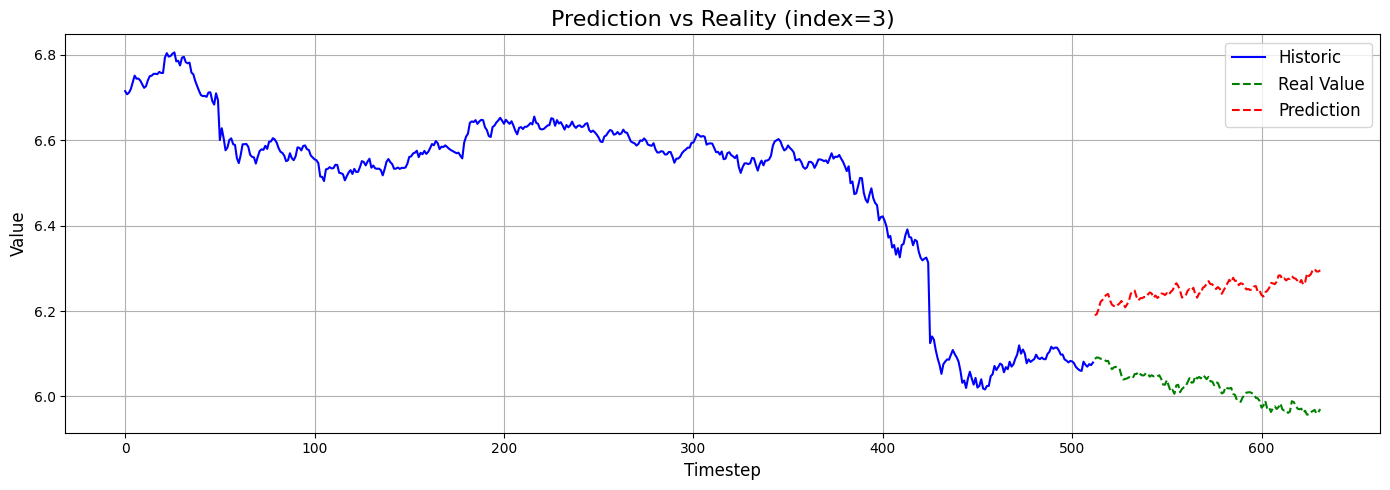

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


channel_idx = 3
time_index = 3

# Extrae los datos correspondientes
history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

# Graficar
plt.figure(figsize=(14, 5))
plt.plot(range(len(history)), history, label='Historic', color='blue')
plt.plot(range(len(history), len(history) + len(true)), true, label='Real Value', color='green', linestyle='--')
plt.plot(range(len(history), len(history) + len(pred)), pred, label='Prediction', color='red', linestyle='--')

plt.title(f"Prediction vs Reality (index={time_index})", fontsize=16)
plt.xlabel("Timestep", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## 5.3 Model specification 3

In [ ]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-base",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 180,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': False, # Freeze the patch embedding layer
        'freeze_embedder': False, # Freeze the transformer encoder
         # The linear forecasting head must be trained
    },
)

In [ ]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=768, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            

/home/fernando/.local/lib/python3.10/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [ ]:
from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x_enc=x)
pprint(output)
#

TimeseriesOutputs(forecast=tensor([[[ 0.1703,  0.0430,  0.4378,  ...,  0.5492,  0.2588,  0.2874]],

        [[-0.0079,  0.2920,  0.2192,  ...,  0.4747,  0.2110,  0.2507]],

        [[-0.0126, -0.0100,  0.4359,  ..., -0.0100,  0.1221,  0.0945]],

        ...,

        [[ 0.0185,  0.0276,  0.0185,  ...,  0.4107, -0.0811,  0.2348]],

        [[ 0.0646,  0.1766,  0.5563,  ...,  0.3747,  0.2119,  0.4272]],

        [[-0.0278,  0.1087,  0.2509,  ...,  0.4551, -0.0018,  0.1695]]],
       grad_fn=<AddBackward0>),
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=None,
                  reconstruction=None,
                  embedding

In [ ]:
from typing import Optional
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


class InformerDataset:
    def __init__(
        self,
        forecast_horizon: Optional[int] = 180,
        data_split: str = "train",
        data_stride_len: int = 1,
        task_name: str = "forecasting",
        random_seed: int = 42,
    ):
        """
        Parameters
        ----------
        forecast_horizon : int
            Length of the prediction sequence.
        data_split : str
            Split of the dataset, 'train' or 'test'.
        data_stride_len : int
            Stride length when generating consecutive
            time series windows.
        task_name : str
            The task that the dataset is used for. One of
            'forecasting', or  'imputation'.
        random_seed : int
            Random seed for reproducibility.
        """

        self.seq_len = 512
        self.forecast_horizon = forecast_horizon
        self.full_file_path_and_name = "Documents/said/intento 6.csv"
        self.data_split = data_split
        self.data_stride_len = data_stride_len
        self.task_name = task_name
        self.random_seed = random_seed

        # Read data
        self._read_data()

    def _get_borders(self):
        total = self.length_timeseries_original
        n_train = int(0.60 * total)
        n_val = int(0.20 * total)
        n_test = total - n_train - n_val

        train_end = n_train
        val_end = n_train + n_val
        test_start = val_end - self.seq_len
        test_end = test_start + n_test + self.seq_len

        train = slice(0, train_end)
        test = slice(test_start, test_end)
        print(f"Train: {train}")
        print(f"Test: {test}")

        return train, test

    def _read_data(self):
        self.scaler = StandardScaler()
        df = pd.read_csv(self.full_file_path_and_name)
        self.length_timeseries_original = df.shape[0]
        self.n_channels = df.shape[1] - 1

        df.drop(columns=["date"], inplace=True)
        df = df.infer_objects(copy=False).interpolate(method="cubic")

        data_splits = self._get_borders()

        train_data = df[data_splits[0]]
        self.scaler.fit(train_data.values)
        df = self.scaler.transform(df.values)

        if self.data_split == "train":
            self.data = df[data_splits[0], :]
        elif self.data_split == "test":
            self.data = df[data_splits[1], :]

        self.length_timeseries = self.data.shape[0]
        print(df)
        print(f"Length of timeseries: {self.length_timeseries}")
        print("Longitud de la serie:", self.length_timeseries)
        print("Seq len:", self.seq_len)
        print("Forecast horizon:", self.forecast_horizon)

    def __getitem__(self, index):
        seq_start = self.data_stride_len * index
        seq_end = seq_start + self.seq_len
        input_mask = np.ones(self.seq_len)

        if self.task_name == "forecasting":
            pred_end = seq_end + self.forecast_horizon

            if pred_end > self.length_timeseries:
                pred_end = self.length_timeseries
                seq_end = seq_end - self.forecast_horizon
                seq_start = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T
            forecast = self.data[seq_end:pred_end, :].T

            return timeseries, forecast, input_mask

        elif self.task_name == "imputation":
            if seq_end > self.length_timeseries:
                seq_end = self.length_timeseries
                seq_end = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T

            return timeseries, input_mask

    def __len__(self):
        if self.task_name == "imputation":
            return (self.length_timeseries - self.seq_len) // self.data_stride_len + 1
        elif self.task_name == "forecasting":
            return (
                self.length_timeseries - self.seq_len - self.forecast_horizon
            ) // self.data_stride_len + 1

In [ ]:
import numpy as np
import torch
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from momentfm.utils.utils import control_randomness
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13)

# Load data
train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=180)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = InformerDataset(data_split="test", random_seed=13, forecast_horizon=180)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cur_epoch = 0
max_epoch = 75

# Move the model to the GPU
model = model.to(device)

# Move the loss function to the GPU
criterion = criterion.to(device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create a OneCycleLR scheduler
max_lr = 1e-4
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping value
max_norm = 5.0

while cur_epoch < max_epoch:
    losses = []
    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)

        with torch.cuda.amp.autocast():
            output = model(x_enc=timeseries, input_mask=input_mask)

        loss = criterion(output.forecast, forecast)

        # Scales the loss for mixed precision training
        scaler.scale(loss).backward()

        # Clip gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    print(f"Epoch {cur_epoch}: Train loss: {average_loss:.3f}")

    # Step the learning rate scheduler
    scheduler.step()
    cur_epoch += 1

    # Evaluate the model on the test split
    trues, preds, histories, losses = [], [], [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in tqdm(test_loader, total=len(test_loader)):
        # Move the data to the GPU
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            with torch.cuda.amp.autocast():
                output = model(x_enc=timeseries, input_mask=input_mask)

            loss = criterion(output.forecast, forecast)
            losses.append(loss.item())

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())
            histories.append(timeseries.detach().cpu().numpy())

    losses = np.array(losses)
    average_loss = np.average(losses)
    model.train()

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)

    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')

    print(f"Epoch {cur_epoch}: Test MSE: {metrics.mse:.3f} | Test MAE: {metrics.mae:.3f}")


Train: slice(0, 11857, None)
Test: slice(15297, 19762, None)
[[-1.79998097 -1.80794455 -1.80637109 -1.8074823 ]
 [-1.80965046 -1.8159859  -1.82833614 -1.83377792]
 [-1.82727244 -1.83622479 -1.83339804 -1.84218167]
 ...
 [ 5.3173981   5.31723015  5.32232753  5.31402224]
 [ 5.31423518  5.31867579  5.31789837  5.31067881]
 [ 5.31025895  5.33069263  5.31645211  5.32712487]]
Length of timeseries: 11857
Longitud de la serie: 11857
Seq len: 512
Forecast horizon: 180
Train: slice(0, 11857, None)
Test: slice(15297, 19762, None)
[[-1.79998097 -1.80794455 -1.80637109 -1.8074823 ]
 [-1.80965046 -1.8159859  -1.82833614 -1.83377792]
 [-1.82727244 -1.83622479 -1.83339804 -1.84218167]
 ...
 [ 5.3173981   5.31723015  5.32232753  5.31402224]
 [ 5.31423518  5.31867579  5.31789837  5.31067881]
 [ 5.31025895  5.33069263  5.31645211  5.32712487]]
Length of timeseries: 4465
Longitud de la serie: 4465
Seq len: 512
Forecast horizon: 180


/tmp/ipykernel_72580/591174682.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|                                                  | 0/1396 [00:00<?, ?it/s]/tmp/ipykernel_72580/591174682.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/fernando/.local/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
100%|████████████████████████████████

Epoch 0: Train loss: 0.035


  0%|                                                   | 0/472 [00:00<?, ?it/s]/tmp/ipykernel_72580/591174682.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.42it/s]


Epoch 1: Test MSE: 0.072 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.07it/s]


Epoch 1: Train loss: 0.019


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.44it/s]


Epoch 2: Test MSE: 0.074 | Test MAE: 0.173


100%|███████████████████████████████████████| 1396/1396 [03:19<00:00,  7.00it/s]


Epoch 2: Train loss: 0.016


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.49it/s]


Epoch 3: Test MSE: 0.072 | Test MAE: 0.172


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.09it/s]


Epoch 3: Train loss: 0.015


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.40it/s]


Epoch 4: Test MSE: 0.076 | Test MAE: 0.177


100%|███████████████████████████████████████| 1396/1396 [03:19<00:00,  7.01it/s]


Epoch 4: Train loss: 0.014


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.65it/s]


Epoch 5: Test MSE: 0.074 | Test MAE: 0.176


100%|███████████████████████████████████████| 1396/1396 [03:28<00:00,  6.70it/s]


Epoch 5: Train loss: 0.013


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.52it/s]


Epoch 6: Test MSE: 0.072 | Test MAE: 0.171


100%|███████████████████████████████████████| 1396/1396 [03:20<00:00,  6.97it/s]


Epoch 6: Train loss: 0.013


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.21it/s]


Epoch 7: Test MSE: 0.071 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:16<00:00,  7.09it/s]


Epoch 7: Train loss: 0.013


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.44it/s]


Epoch 8: Test MSE: 0.070 | Test MAE: 0.169


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.08it/s]


Epoch 8: Train loss: 0.013


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.50it/s]


Epoch 9: Test MSE: 0.069 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:26<00:00,  6.77it/s]


Epoch 9: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.49it/s]


Epoch 10: Test MSE: 0.069 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:25<00:00,  6.80it/s]


Epoch 10: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.26it/s]


Epoch 11: Test MSE: 0.069 | Test MAE: 0.169


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.07it/s]


Epoch 11: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.47it/s]


Epoch 12: Test MSE: 0.069 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:18<00:00,  7.03it/s]


Epoch 12: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.47it/s]


Epoch 13: Test MSE: 0.069 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.07it/s]


Epoch 13: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.45it/s]


Epoch 14: Test MSE: 0.069 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.06it/s]


Epoch 14: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.51it/s]


Epoch 15: Test MSE: 0.069 | Test MAE: 0.169


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.08it/s]


Epoch 15: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.52it/s]


Epoch 16: Test MSE: 0.068 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:22<00:00,  6.90it/s]


Epoch 16: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.33it/s]


Epoch 17: Test MSE: 0.065 | Test MAE: 0.165


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.07it/s]


Epoch 17: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.44it/s]


Epoch 18: Test MSE: 0.066 | Test MAE: 0.166


100%|███████████████████████████████████████| 1396/1396 [03:18<00:00,  7.03it/s]


Epoch 18: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.51it/s]


Epoch 19: Test MSE: 0.068 | Test MAE: 0.167


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.07it/s]


Epoch 19: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.36it/s]


Epoch 20: Test MSE: 0.066 | Test MAE: 0.166


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.07it/s]


Epoch 20: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.32it/s]


Epoch 21: Test MSE: 0.067 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.06it/s]


Epoch 21: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.53it/s]


Epoch 22: Test MSE: 0.067 | Test MAE: 0.167


100%|███████████████████████████████████████| 1396/1396 [03:18<00:00,  7.05it/s]


Epoch 22: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.30it/s]


Epoch 23: Test MSE: 0.068 | Test MAE: 0.169


100%|███████████████████████████████████████| 1396/1396 [03:19<00:00,  7.01it/s]


Epoch 23: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.49it/s]


Epoch 24: Test MSE: 0.067 | Test MAE: 0.167


100%|███████████████████████████████████████| 1396/1396 [03:22<00:00,  6.88it/s]


Epoch 24: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.56it/s]


Epoch 25: Test MSE: 0.068 | Test MAE: 0.167


100%|███████████████████████████████████████| 1396/1396 [03:08<00:00,  7.40it/s]


Epoch 25: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.50it/s]


Epoch 26: Test MSE: 0.068 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.07it/s]


Epoch 26: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.41it/s]


Epoch 27: Test MSE: 0.068 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:18<00:00,  7.04it/s]


Epoch 27: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.38it/s]


Epoch 28: Test MSE: 0.067 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.07it/s]


Epoch 28: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.67it/s]


Epoch 29: Test MSE: 0.068 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.06it/s]


Epoch 29: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.33it/s]


Epoch 30: Test MSE: 0.068 | Test MAE: 0.169


100%|███████████████████████████████████████| 1396/1396 [03:36<00:00,  6.45it/s]


Epoch 30: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.67it/s]


Epoch 31: Test MSE: 0.067 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.07it/s]


Epoch 31: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.55it/s]


Epoch 32: Test MSE: 0.068 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:18<00:00,  7.05it/s]


Epoch 32: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.58it/s]


Epoch 33: Test MSE: 0.067 | Test MAE: 0.169


100%|███████████████████████████████████████| 1396/1396 [03:38<00:00,  6.38it/s]


Epoch 33: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.45it/s]


Epoch 34: Test MSE: 0.067 | Test MAE: 0.169


100%|███████████████████████████████████████| 1396/1396 [03:21<00:00,  6.93it/s]


Epoch 34: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.54it/s]


Epoch 35: Test MSE: 0.067 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:42<00:00,  6.28it/s]


Epoch 35: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.75it/s]


Epoch 36: Test MSE: 0.067 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:22<00:00,  6.88it/s]


Epoch 36: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.28it/s]


Epoch 37: Test MSE: 0.069 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:33<00:00,  6.54it/s]


Epoch 37: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.52it/s]


Epoch 38: Test MSE: 0.066 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:30<00:00,  6.64it/s]


Epoch 38: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.53it/s]


Epoch 39: Test MSE: 0.067 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:18<00:00,  7.03it/s]


Epoch 39: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.41it/s]


Epoch 40: Test MSE: 0.068 | Test MAE: 0.169


100%|███████████████████████████████████████| 1396/1396 [03:21<00:00,  6.92it/s]


Epoch 40: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.56it/s]


Epoch 41: Test MSE: 0.068 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:23<00:00,  6.87it/s]


Epoch 41: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.34it/s]


Epoch 42: Test MSE: 0.068 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:25<00:00,  6.81it/s]


Epoch 42: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.40it/s]


Epoch 43: Test MSE: 0.069 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:26<00:00,  6.75it/s]


Epoch 43: Train loss: 0.012


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.43it/s]


Epoch 44: Test MSE: 0.068 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:33<00:00,  6.55it/s]


Epoch 44: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.58it/s]


Epoch 45: Test MSE: 0.067 | Test MAE: 0.168


100%|███████████████████████████████████████| 1396/1396 [03:40<00:00,  6.33it/s]


Epoch 45: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.57it/s]


Epoch 46: Test MSE: 0.068 | Test MAE: 0.169


100%|███████████████████████████████████████| 1396/1396 [03:34<00:00,  6.52it/s]


Epoch 46: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.33it/s]


Epoch 47: Test MSE: 0.068 | Test MAE: 0.169


100%|███████████████████████████████████████| 1396/1396 [03:34<00:00,  6.51it/s]


Epoch 47: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.44it/s]


Epoch 48: Test MSE: 0.067 | Test MAE: 0.169


100%|███████████████████████████████████████| 1396/1396 [03:26<00:00,  6.76it/s]


Epoch 48: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 50.45it/s]


Epoch 49: Test MSE: 0.068 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:41<00:00,  6.31it/s]


Epoch 49: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.48it/s]


Epoch 50: Test MSE: 0.068 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:36<00:00,  6.46it/s]


Epoch 50: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.42it/s]


Epoch 51: Test MSE: 0.068 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:19<00:00,  7.00it/s]


Epoch 51: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.51it/s]


Epoch 52: Test MSE: 0.068 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:28<00:00,  6.68it/s]


Epoch 52: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.52it/s]


Epoch 53: Test MSE: 0.069 | Test MAE: 0.171


100%|███████████████████████████████████████| 1396/1396 [03:41<00:00,  6.29it/s]


Epoch 53: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.59it/s]


Epoch 54: Test MSE: 0.068 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:41<00:00,  6.31it/s]


Epoch 54: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.58it/s]


Epoch 55: Test MSE: 0.069 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:35<00:00,  6.47it/s]


Epoch 55: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.56it/s]


Epoch 56: Test MSE: 0.068 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:32<00:00,  6.56it/s]


Epoch 56: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.47it/s]


Epoch 57: Test MSE: 0.069 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:39<00:00,  6.36it/s]


Epoch 57: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.37it/s]


Epoch 58: Test MSE: 0.069 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:35<00:00,  6.47it/s]


Epoch 58: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.53it/s]


Epoch 59: Test MSE: 0.068 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:36<00:00,  6.44it/s]


Epoch 59: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.54it/s]


Epoch 60: Test MSE: 0.069 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:41<00:00,  6.29it/s]


Epoch 60: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.59it/s]


Epoch 61: Test MSE: 0.069 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:35<00:00,  6.46it/s]


Epoch 61: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.57it/s]


Epoch 62: Test MSE: 0.069 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:41<00:00,  6.29it/s]


Epoch 62: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.59it/s]


Epoch 63: Test MSE: 0.068 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:41<00:00,  6.29it/s]


Epoch 63: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.57it/s]


Epoch 64: Test MSE: 0.068 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:39<00:00,  6.35it/s]


Epoch 64: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.56it/s]


Epoch 65: Test MSE: 0.069 | Test MAE: 0.171


100%|███████████████████████████████████████| 1396/1396 [03:41<00:00,  6.30it/s]


Epoch 65: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.55it/s]


Epoch 66: Test MSE: 0.069 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:33<00:00,  6.54it/s]


Epoch 66: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.48it/s]


Epoch 67: Test MSE: 0.068 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:20<00:00,  6.97it/s]


Epoch 67: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.47it/s]


Epoch 68: Test MSE: 0.068 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:28<00:00,  6.68it/s]


Epoch 68: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.43it/s]


Epoch 69: Test MSE: 0.068 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:18<00:00,  7.04it/s]


Epoch 69: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.48it/s]


Epoch 70: Test MSE: 0.069 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.08it/s]


Epoch 70: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.53it/s]


Epoch 71: Test MSE: 0.069 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:18<00:00,  7.05it/s]


Epoch 71: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.38it/s]


Epoch 72: Test MSE: 0.068 | Test MAE: 0.169


100%|███████████████████████████████████████| 1396/1396 [03:18<00:00,  7.05it/s]


Epoch 72: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.47it/s]


Epoch 73: Test MSE: 0.068 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.08it/s]


Epoch 73: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.36it/s]


Epoch 74: Test MSE: 0.069 | Test MAE: 0.170


100%|███████████████████████████████████████| 1396/1396 [03:17<00:00,  7.08it/s]


Epoch 74: Train loss: 0.011


100%|█████████████████████████████████████████| 472/472 [00:09<00:00, 51.42it/s]

Epoch 75: Test MSE: 0.068 | Test MAE: 0.170


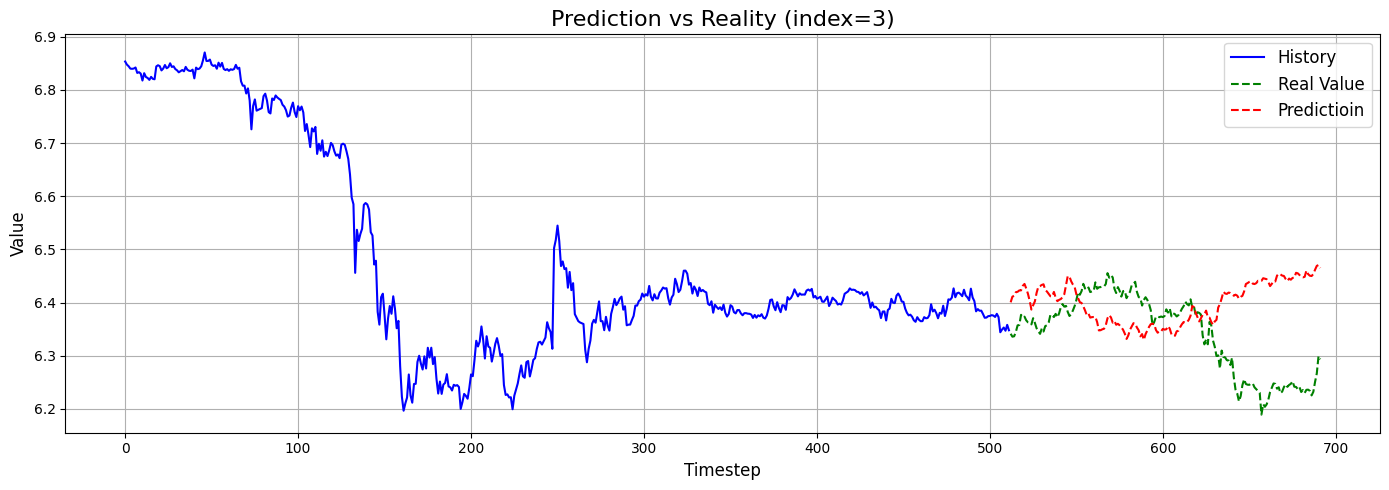

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

channel_idx = 3
time_index = 3

# Extrae los datos correspondientes
history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

# Graficar
plt.figure(figsize=(14, 5))
plt.plot(range(len(history)), history, label='History', color='blue')
plt.plot(range(len(history), len(history) + len(true)), true, label='Real Value', color='green', linestyle='--')
plt.plot(range(len(history), len(history) + len(pred)), pred, label='Predictioin', color='red', linestyle='--')

plt.title(f"Prediction vs Reality (index={time_index})", fontsize=16)
plt.xlabel("Timestep", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## 5.4  Model Specification 4  

In [ ]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-base",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 240,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': False, # Freeze the patch embedding layer
        'freeze_embedder': False, # Freeze the transformer encoder
         # The linear forecasting head must be trained
    },
)

In [ ]:
model.init()
print(model)


MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=768, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            

/home/fernando/.local/lib/python3.10/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [ ]:
from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x_enc=x)
pprint(output)

TimeseriesOutputs(forecast=tensor([[[-0.0585,  0.1840,  0.3430,  ...,  0.0169,  0.1497,  0.2618]],

        [[ 0.0793,  0.1422,  0.4210,  ..., -0.1017,  0.2309,  0.0819]],

        [[ 0.2129,  0.0297,  0.2888,  ...,  0.0297,  0.3732,  0.0571]],

        ...,

        [[ 0.1044,  0.1050,  0.3847,  ...,  0.0817,  0.5161, -0.1544]],

        [[ 0.1135,  0.0444,  0.1701,  ...,  0.2258,  0.3307,  0.0889]],

        [[-0.0157,  0.1677,  0.3007,  ...,  0.0286,  0.1331, -0.0476]]],
       grad_fn=<AddBackward0>),
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=None,
                  reconstruction=None,
                  embedding

In [ ]:
from typing import Optional
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


class InformerDataset:
    def __init__(
        self,
        forecast_horizon: Optional[int] = 240,
        data_split: str = "train",
        data_stride_len: int = 1,
        task_name: str = "forecasting",
        random_seed: int = 42,
    ):
        """
        Parameters
        ----------
        forecast_horizon : int
            Length of the prediction sequence.
        data_split : str
            Split of the dataset, 'train' or 'test'.
        data_stride_len : int
            Stride length when generating consecutive
            time series windows.
        task_name : str
            The task that the dataset is used for. One of
            'forecasting', or  'imputation'.
        random_seed : int
            Random seed for reproducibility.
        """

        self.seq_len = 512
        self.forecast_horizon = forecast_horizon
        self.full_file_path_and_name = "Documents/said/intento 6.csv"
        self.data_split = data_split
        self.data_stride_len = data_stride_len
        self.task_name = task_name
        self.random_seed = random_seed

        # Read data
        self._read_data()

    def _get_borders(self):
        total = self.length_timeseries_original
        n_train = int(0.60 * total)
        n_val = int(0.20 * total)
        n_test = total - n_train - n_val

        train_end = n_train
        val_end = n_train + n_val
        test_start = val_end - self.seq_len
        test_end = test_start + n_test + self.seq_len

        train = slice(0, train_end)
        test = slice(test_start, test_end)
        print(f"Train: {train}")
        print(f"Test: {test}")

        return train, test

    def _read_data(self):
        self.scaler = StandardScaler()
        df = pd.read_csv(self.full_file_path_and_name)
        self.length_timeseries_original = df.shape[0]
        self.n_channels = df.shape[1] - 1

        df.drop(columns=["date"], inplace=True)
        df = df.infer_objects(copy=False).interpolate(method="cubic")

        data_splits = self._get_borders()

        train_data = df[data_splits[0]]
        self.scaler.fit(train_data.values)
        df = self.scaler.transform(df.values)

        if self.data_split == "train":
            self.data = df[data_splits[0], :]
        elif self.data_split == "test":
            self.data = df[data_splits[1], :]

        self.length_timeseries = self.data.shape[0]
        print(df)
        print(f"Length of timeseries: {self.length_timeseries}")
        print("Longitud de la serie:", self.length_timeseries)
        print("Seq len:", self.seq_len)
        print("Forecast horizon:", self.forecast_horizon)

    def __getitem__(self, index):
        seq_start = self.data_stride_len * index
        seq_end = seq_start + self.seq_len
        input_mask = np.ones(self.seq_len)

        if self.task_name == "forecasting":
            pred_end = seq_end + self.forecast_horizon

            if pred_end > self.length_timeseries:
                pred_end = self.length_timeseries
                seq_end = seq_end - self.forecast_horizon
                seq_start = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T
            forecast = self.data[seq_end:pred_end, :].T

            return timeseries, forecast, input_mask

        elif self.task_name == "imputation":
            if seq_end > self.length_timeseries:
                seq_end = self.length_timeseries
                seq_end = seq_end - self.seq_len

            timeseries = self.data[seq_start:seq_end, :].T

            return timeseries, input_mask

    def __len__(self):
        if self.task_name == "imputation":
            return (self.length_timeseries - self.seq_len) // self.data_stride_len + 1
        elif self.task_name == "forecasting":
            return (
                self.length_timeseries - self.seq_len - self.forecast_horizon
            ) // self.data_stride_len + 1

In [ ]:
import numpy as np
import torch
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from momentfm.utils.utils import control_randomness
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13)

# Load data
train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=240)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = InformerDataset(data_split="test", random_seed=13, forecast_horizon=240)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cur_epoch = 0
max_epoch = 75

# Move the model to the GPU
model = model.to(device)

# Move the loss function to the GPU
criterion = criterion.to(device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create a OneCycleLR scheduler
max_lr = 1e-4
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping value
max_norm = 5.0

while cur_epoch < max_epoch:
    losses = []
    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)

        with torch.cuda.amp.autocast():
            output = model(x_enc=timeseries, input_mask=input_mask)

        loss = criterion(output.forecast, forecast)

        # Scales the loss for mixed precision training
        scaler.scale(loss).backward()

        # Clip gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    print(f"Epoch {cur_epoch}: Train loss: {average_loss:.3f}")

    # Step the learning rate scheduler
    scheduler.step()
    cur_epoch += 1

    # Evaluate the model on the test split
    trues, preds, histories, losses = [], [], [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in tqdm(test_loader, total=len(test_loader)):
        # Move the data to the GPU
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            with torch.cuda.amp.autocast():
                output = model(x_enc=timeseries, input_mask=input_mask)

            loss = criterion(output.forecast, forecast)
            losses.append(loss.item())

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())
            histories.append(timeseries.detach().cpu().numpy())

    losses = np.array(losses)
    average_loss = np.average(losses)
    model.train()

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)

    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')

    print(f"Epoch {cur_epoch}: Test MSE: {metrics.mse:.3f} | Test MAE: {metrics.mae:.3f}")


Train: slice(0, 11857, None)
Test: slice(15297, 19762, None)
[[-1.79998097 -1.80794455 -1.80637109 -1.8074823 ]
 [-1.80965046 -1.8159859  -1.82833614 -1.83377792]
 [-1.82727244 -1.83622479 -1.83339804 -1.84218167]
 ...
 [ 5.3173981   5.31723015  5.32232753  5.31402224]
 [ 5.31423518  5.31867579  5.31789837  5.31067881]
 [ 5.31025895  5.33069263  5.31645211  5.32712487]]
Length of timeseries: 11857
Longitud de la serie: 11857
Seq len: 512
Forecast horizon: 240
Train: slice(0, 11857, None)
Test: slice(15297, 19762, None)
[[-1.79998097 -1.80794455 -1.80637109 -1.8074823 ]
 [-1.80965046 -1.8159859  -1.82833614 -1.83377792]
 [-1.82727244 -1.83622479 -1.83339804 -1.84218167]
 ...
 [ 5.3173981   5.31723015  5.32232753  5.31402224]
 [ 5.31423518  5.31867579  5.31789837  5.31067881]
 [ 5.31025895  5.33069263  5.31645211  5.32712487]]
Length of timeseries: 4465
Longitud de la serie: 4465
Seq len: 512
Forecast horizon: 240


/tmp/ipykernel_72580/3284964998.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|                                                  | 0/1389 [00:00<?, ?it/s]/tmp/ipykernel_72580/3284964998.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/fernando/.local/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
100%|██████████████████████████████

Epoch 0: Train loss: 0.042


  0%|                                                   | 0/465 [00:00<?, ?it/s]/tmp/ipykernel_72580/3284964998.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.32it/s]


Epoch 1: Test MSE: 0.099 | Test MAE: 0.195


100%|███████████████████████████████████████| 1389/1389 [03:32<00:00,  6.53it/s]


Epoch 1: Train loss: 0.022


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.44it/s]


Epoch 2: Test MSE: 0.110 | Test MAE: 0.211


100%|███████████████████████████████████████| 1389/1389 [03:22<00:00,  6.85it/s]


Epoch 2: Train loss: 0.018


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.37it/s]


Epoch 3: Test MSE: 0.110 | Test MAE: 0.213


100%|███████████████████████████████████████| 1389/1389 [03:18<00:00,  7.01it/s]


Epoch 3: Train loss: 0.017


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.42it/s]


Epoch 4: Test MSE: 0.102 | Test MAE: 0.206


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.03it/s]


Epoch 4: Train loss: 0.016


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.45it/s]


Epoch 5: Test MSE: 0.100 | Test MAE: 0.203


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.05it/s]


Epoch 5: Train loss: 0.015


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.34it/s]


Epoch 6: Test MSE: 0.102 | Test MAE: 0.206


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.04it/s]


Epoch 6: Train loss: 0.015


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.31it/s]


Epoch 7: Test MSE: 0.100 | Test MAE: 0.204


100%|███████████████████████████████████████| 1389/1389 [03:19<00:00,  6.97it/s]


Epoch 7: Train loss: 0.014


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.31it/s]


Epoch 8: Test MSE: 0.099 | Test MAE: 0.204


100%|███████████████████████████████████████| 1389/1389 [03:18<00:00,  7.01it/s]


Epoch 8: Train loss: 0.014


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.40it/s]


Epoch 9: Test MSE: 0.101 | Test MAE: 0.205


100%|███████████████████████████████████████| 1389/1389 [03:20<00:00,  6.92it/s]


Epoch 9: Train loss: 0.014


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.35it/s]


Epoch 10: Test MSE: 0.098 | Test MAE: 0.199


100%|███████████████████████████████████████| 1389/1389 [03:18<00:00,  6.99it/s]


Epoch 10: Train loss: 0.014


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.17it/s]


Epoch 11: Test MSE: 0.098 | Test MAE: 0.200


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.05it/s]


Epoch 11: Train loss: 0.014


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.36it/s]


Epoch 12: Test MSE: 0.101 | Test MAE: 0.203


100%|███████████████████████████████████████| 1389/1389 [03:15<00:00,  7.09it/s]


Epoch 12: Train loss: 0.014


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.41it/s]


Epoch 13: Test MSE: 0.100 | Test MAE: 0.202


100%|███████████████████████████████████████| 1389/1389 [03:14<00:00,  7.14it/s]


Epoch 13: Train loss: 0.014


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.41it/s]


Epoch 14: Test MSE: 0.098 | Test MAE: 0.199


100%|███████████████████████████████████████| 1389/1389 [03:16<00:00,  7.07it/s]


Epoch 14: Train loss: 0.014


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.51it/s]


Epoch 15: Test MSE: 0.099 | Test MAE: 0.199


100%|███████████████████████████████████████| 1389/1389 [03:15<00:00,  7.09it/s]


Epoch 15: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.35it/s]


Epoch 16: Test MSE: 0.099 | Test MAE: 0.200


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.03it/s]


Epoch 16: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.44it/s]


Epoch 17: Test MSE: 0.097 | Test MAE: 0.197


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.02it/s]


Epoch 17: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.51it/s]


Epoch 18: Test MSE: 0.097 | Test MAE: 0.197


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.05it/s]


Epoch 18: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.25it/s]


Epoch 19: Test MSE: 0.097 | Test MAE: 0.198


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.04it/s]


Epoch 19: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.13it/s]


Epoch 20: Test MSE: 0.097 | Test MAE: 0.197


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.03it/s]


Epoch 20: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.32it/s]


Epoch 21: Test MSE: 0.097 | Test MAE: 0.197


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.02it/s]


Epoch 21: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.39it/s]


Epoch 22: Test MSE: 0.096 | Test MAE: 0.197


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.03it/s]


Epoch 22: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.32it/s]


Epoch 23: Test MSE: 0.097 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:18<00:00,  7.01it/s]


Epoch 23: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.43it/s]


Epoch 24: Test MSE: 0.097 | Test MAE: 0.197


100%|███████████████████████████████████████| 1389/1389 [03:18<00:00,  7.00it/s]


Epoch 24: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.31it/s]


Epoch 25: Test MSE: 0.096 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:34<00:00,  6.48it/s]


Epoch 25: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.42it/s]


Epoch 26: Test MSE: 0.097 | Test MAE: 0.197


100%|███████████████████████████████████████| 1389/1389 [03:33<00:00,  6.49it/s]


Epoch 26: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.49it/s]


Epoch 27: Test MSE: 0.096 | Test MAE: 0.197


100%|███████████████████████████████████████| 1389/1389 [03:22<00:00,  6.85it/s]


Epoch 27: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.26it/s]


Epoch 28: Test MSE: 0.097 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:10<00:00,  7.31it/s]


Epoch 28: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.26it/s]


Epoch 29: Test MSE: 0.095 | Test MAE: 0.194


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.03it/s]


Epoch 29: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.19it/s]


Epoch 30: Test MSE: 0.096 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:03<00:00,  7.58it/s]


Epoch 30: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.05it/s]


Epoch 31: Test MSE: 0.096 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:18<00:00,  7.00it/s]


Epoch 31: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.28it/s]


Epoch 32: Test MSE: 0.096 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:19<00:00,  6.97it/s]


Epoch 32: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.46it/s]


Epoch 33: Test MSE: 0.097 | Test MAE: 0.197


100%|███████████████████████████████████████| 1389/1389 [03:33<00:00,  6.50it/s]


Epoch 33: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.45it/s]


Epoch 34: Test MSE: 0.096 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:20<00:00,  6.94it/s]


Epoch 34: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.21it/s]


Epoch 35: Test MSE: 0.098 | Test MAE: 0.198


100%|███████████████████████████████████████| 1389/1389 [03:18<00:00,  6.99it/s]


Epoch 35: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.13it/s]


Epoch 36: Test MSE: 0.097 | Test MAE: 0.197


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.02it/s]


Epoch 36: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.22it/s]


Epoch 37: Test MSE: 0.098 | Test MAE: 0.198


100%|███████████████████████████████████████| 1389/1389 [03:18<00:00,  6.99it/s]


Epoch 37: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.44it/s]


Epoch 38: Test MSE: 0.096 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:18<00:00,  6.99it/s]


Epoch 38: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.27it/s]


Epoch 39: Test MSE: 0.096 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:22<00:00,  6.86it/s]


Epoch 39: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.15it/s]


Epoch 40: Test MSE: 0.096 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:20<00:00,  6.92it/s]


Epoch 40: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.39it/s]


Epoch 41: Test MSE: 0.096 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:38<00:00,  6.36it/s]


Epoch 41: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 47.27it/s]


Epoch 42: Test MSE: 0.095 | Test MAE: 0.195


100%|███████████████████████████████████████| 1389/1389 [03:44<00:00,  6.18it/s]


Epoch 42: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 47.48it/s]


Epoch 43: Test MSE: 0.097 | Test MAE: 0.197


100%|███████████████████████████████████████| 1389/1389 [03:38<00:00,  6.36it/s]


Epoch 43: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 47.27it/s]


Epoch 44: Test MSE: 0.096 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:44<00:00,  6.18it/s]


Epoch 44: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 47.46it/s]


Epoch 45: Test MSE: 0.096 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:35<00:00,  6.44it/s]


Epoch 45: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.39it/s]


Epoch 46: Test MSE: 0.096 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:27<00:00,  6.68it/s]


Epoch 46: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.30it/s]


Epoch 47: Test MSE: 0.097 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:28<00:00,  6.66it/s]


Epoch 47: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.30it/s]


Epoch 48: Test MSE: 0.096 | Test MAE: 0.195


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.04it/s]


Epoch 48: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.42it/s]


Epoch 49: Test MSE: 0.095 | Test MAE: 0.195


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.02it/s]


Epoch 49: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.31it/s]


Epoch 50: Test MSE: 0.095 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:16<00:00,  7.06it/s]


Epoch 50: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.40it/s]


Epoch 51: Test MSE: 0.096 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.03it/s]


Epoch 51: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.47it/s]


Epoch 52: Test MSE: 0.096 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.03it/s]


Epoch 52: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.29it/s]


Epoch 53: Test MSE: 0.095 | Test MAE: 0.195


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.04it/s]


Epoch 53: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.47it/s]


Epoch 54: Test MSE: 0.095 | Test MAE: 0.195


100%|███████████████████████████████████████| 1389/1389 [03:20<00:00,  6.94it/s]


Epoch 54: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.43it/s]


Epoch 55: Test MSE: 0.096 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:16<00:00,  7.05it/s]


Epoch 55: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 50.54it/s]


Epoch 56: Test MSE: 0.095 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.02it/s]


Epoch 56: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.42it/s]


Epoch 57: Test MSE: 0.095 | Test MAE: 0.194


100%|███████████████████████████████████████| 1389/1389 [03:11<00:00,  7.26it/s]


Epoch 57: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.38it/s]


Epoch 58: Test MSE: 0.095 | Test MAE: 0.195


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.02it/s]


Epoch 58: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.22it/s]


Epoch 59: Test MSE: 0.095 | Test MAE: 0.195


100%|███████████████████████████████████████| 1389/1389 [03:18<00:00,  7.01it/s]


Epoch 59: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.24it/s]


Epoch 60: Test MSE: 0.096 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:18<00:00,  7.00it/s]


Epoch 60: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.42it/s]


Epoch 61: Test MSE: 0.095 | Test MAE: 0.194


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.02it/s]


Epoch 61: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.42it/s]


Epoch 62: Test MSE: 0.097 | Test MAE: 0.197


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.03it/s]


Epoch 62: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.44it/s]


Epoch 63: Test MSE: 0.095 | Test MAE: 0.194


100%|███████████████████████████████████████| 1389/1389 [03:18<00:00,  6.99it/s]


Epoch 63: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.10it/s]


Epoch 64: Test MSE: 0.096 | Test MAE: 0.196


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.02it/s]


Epoch 64: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.03it/s]


Epoch 65: Test MSE: 0.095 | Test MAE: 0.195


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.05it/s]


Epoch 65: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.44it/s]


Epoch 66: Test MSE: 0.094 | Test MAE: 0.194


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.03it/s]


Epoch 66: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.28it/s]


Epoch 67: Test MSE: 0.096 | Test MAE: 0.195


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.02it/s]


Epoch 67: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.24it/s]


Epoch 68: Test MSE: 0.095 | Test MAE: 0.195


100%|███████████████████████████████████████| 1389/1389 [03:17<00:00,  7.02it/s]


Epoch 68: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.24it/s]


Epoch 69: Test MSE: 0.095 | Test MAE: 0.195


100%|███████████████████████████████████████| 1389/1389 [03:18<00:00,  6.99it/s]


Epoch 69: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.24it/s]


Epoch 70: Test MSE: 0.095 | Test MAE: 0.194


100%|███████████████████████████████████████| 1389/1389 [03:19<00:00,  6.97it/s]


Epoch 70: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 50.34it/s]


Epoch 71: Test MSE: 0.094 | Test MAE: 0.194


100%|███████████████████████████████████████| 1389/1389 [03:20<00:00,  6.93it/s]


Epoch 71: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.19it/s]


Epoch 72: Test MSE: 0.095 | Test MAE: 0.195


100%|███████████████████████████████████████| 1389/1389 [03:19<00:00,  6.96it/s]


Epoch 72: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.25it/s]


Epoch 73: Test MSE: 0.095 | Test MAE: 0.194


100%|███████████████████████████████████████| 1389/1389 [03:18<00:00,  6.99it/s]


Epoch 73: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.21it/s]


Epoch 74: Test MSE: 0.095 | Test MAE: 0.193


100%|███████████████████████████████████████| 1389/1389 [03:18<00:00,  7.00it/s]


Epoch 74: Train loss: 0.013


100%|█████████████████████████████████████████| 465/465 [00:09<00:00, 51.30it/s]


Epoch 75: Test MSE: 0.095 | Test MAE: 0.195


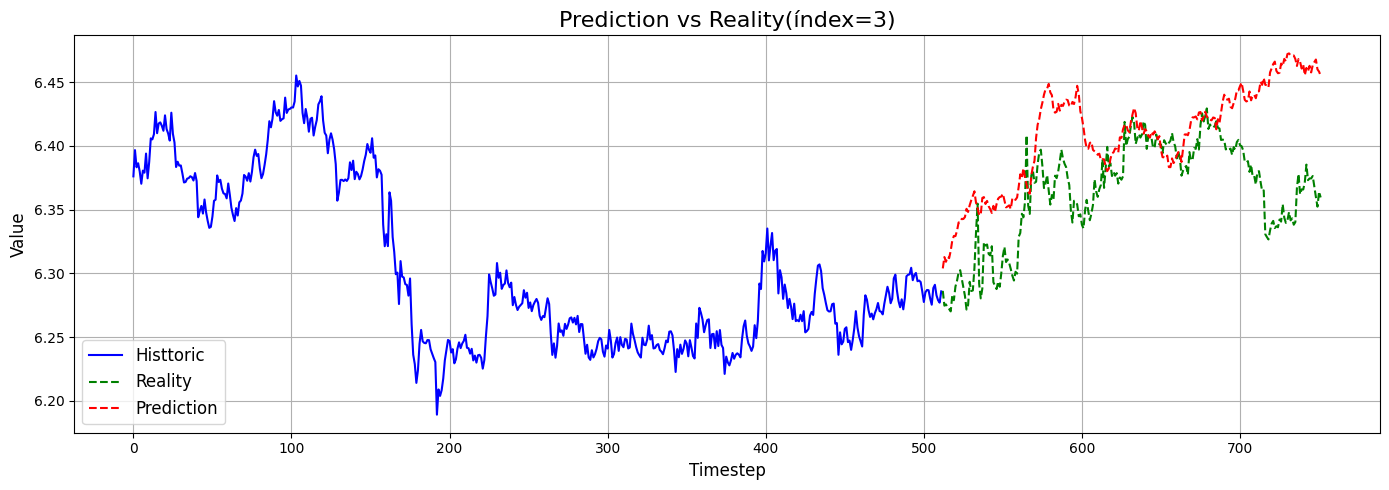

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


channel_idx = 3
time_index = 3

# Extrae los datos correspondientes
history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

# Graficar
plt.figure(figsize=(14, 5))
plt.plot(range(len(history)), history, label='Histtoric', color='blue')
plt.plot(range(len(history), len(history) + len(true)), true, label='Reality', color='green', linestyle='--')
plt.plot(range(len(history), len(history) + len(pred)), pred, label='Prediction', color='red', linestyle='--')

plt.title(f"Prediction vs Reality(índex={time_index})", fontsize=16)
plt.xlabel("Timestep", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Conclusion
Upon reviewing both the numerical results and the visualizations, it becomes evident that the model still
struggles to learn consistently. However, its performance improves significantly when the forecast
horizon is reduced. For instance, in a test using only one prediction time step, the model achieved an
MSE of 0.002 and an MAE of 0.031—substantially outperforming the results shown in Table 1.
This suggests that, given the difficulty of anticipating fluctuations in stock prices, a forecast horizon of 60
days or fewer would be optimal—at least in this specific case. It is also worth noting that this analysis
relied solely on historical stock prices, without incorporating any exogenous variables that could
potentially improve prediction accuracy—a commonly used approach in time series forecasting